# SMM4H 2026 Task 1 — Multilingual ADE Detection (EN/DE train, FR zero-shot)

This notebook implements the full exercise end-to-end in a **single file**:

- **Task 1.1**: Language selection (EN/DE train, FR eval-only), train/val/test splits (dev→test), preprocessing, EN→FR translation of **6000 EN train** samples stratified by label.
- **Task 1.2**: Multilingual exploration (label distribution, size differences, text length/type characteristics, manual inspection).
- **Task 1.3**: Modeling with the **same backbone** across setups (default: `xlm-roberta-base`):
  - Monolingual EN, monolingual DE
  - Multilingual EN+DE
  - Translation-trained (EN→FR translated train)
- **Task 1.4**: Evaluation (F1/precision/recall/accuracy, confusion matrices, per-language results) + cross-lingual error analysis.

## Model backbone swap (XLM-R → Microsoft multilingual model)
This notebook uses a single config variable `MODEL_NAME`. To switch to Microsoft’s multilingual model later:

- Change `MODEL_NAME = "xlm-roberta-base"` to:
  - `MODEL_NAME = "microsoft/mdeberta-v3-base"` (recommended)
  - or `MODEL_NAME = "microsoft/mdeberta-v3-large"` (heavier)

No other code changes should be required.


In [12]:
# Environment & reproducibility
import os
import re
import json
import math
import random
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, Iterable, List, Optional, Tuple

import numpy as np
import pandas as pd

import torch

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
)

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    EarlyStoppingCallback,
    TrainingArguments,
    Trainer,
    set_seed,
)

import matplotlib.pyplot as plt
import seaborn as sns

print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("gpu:", torch.cuda.get_device_name(0))

SEED = 42
set_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

auto_device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", auto_device)

ROOT = Path(".").resolve()
DATASET_DIR = ROOT / "dataset"
ARTIFACTS_DIR = ROOT / "artifacts"
ARTIFACTS_DIR.mkdir(exist_ok=True)

# Core experiment config
MODEL_NAME = "xlm-roberta-base"  # swap to "microsoft/mdeberta-v3-base" later
MAX_LENGTH = 256
VAL_FRACTION = 0.1
BATCH_SIZE = 16
EPOCHS = 10
EARLY_STOPPING_PATIENCE = 3
LR = 2e-5
WEIGHT_DECAY = 0.01

TRAIN_LANGS = ["en", "de"]
ZERO_SHOT_LANG = "fr"

TRANSLATE_N = 6000
TRANSLATION_MODEL_NAME = "Helsinki-NLP/opus-mt-en-fr"  # offline MT via MarianMT

# If you need a quick smoke run, set this to True (uses smaller subsets)
DEBUG_SMALL = False

cfg = {
    "seed": SEED,
    "model_name": MODEL_NAME,
    "max_length": MAX_LENGTH,
    "val_fraction": VAL_FRACTION,
    "batch_size": BATCH_SIZE,
    "epochs": EPOCHS,
    "early_stopping_patience": EARLY_STOPPING_PATIENCE,
    "lr": LR,
    "weight_decay": WEIGHT_DECAY,
    "train_langs": TRAIN_LANGS,
    "zero_shot_lang": ZERO_SHOT_LANG,
    "translate_n": TRANSLATE_N,
    "translation_model": TRANSLATION_MODEL_NAME,
}
print(json.dumps(cfg, indent=2))



torch: 2.9.1
cuda available: True
gpu: NVIDIA RTX 2000 Ada Generation Laptop GPU
device: cuda
{
  "seed": 42,
  "model_name": "xlm-roberta-base",
  "max_length": 256,
  "val_fraction": 0.1,
  "batch_size": 16,
  "epochs": 10,
  "early_stopping_patience": 3,
  "lr": 2e-05,
  "weight_decay": 0.01,
  "train_langs": [
    "en",
    "de"
  ],
  "zero_shot_lang": "fr",
  "translate_n": 6000,
  "translation_model": "Helsinki-NLP/opus-mt-en-fr"
}


In [4]:
# Pandas/Jupyter display tweaks: wrap long text and allow horizontal scrolling
from IPython.display import HTML, display

# Prevent pandas from truncating long strings (e.g., the `text` column)
pd.set_option("display.max_colwidth", None)

# Make rendered DataFrame tables wrap text and scroll horizontally if needed
display(HTML("""
<style>
div.dataframe {
  overflow-x: auto;
}
div.dataframe table {
  width: 100%;
  table-layout: fixed;
}
div.dataframe td, div.dataframe th {
  vertical-align: top;
}
div.dataframe td {
  white-space: pre-wrap;
  word-break: break-word;
}
</style>
"""))

## Task 1.1 — Load CSVs (train) + redefine dev as test

We keep **French (fr)** as evaluation-only (zero-shot), and train only on **English (en)** and **German (de)**.

Preprocessing decisions (minimal, ADE-preserving):
- Normalize user mentions to `@USER`.
- Normalize URLs to `HTTPURL`.
- Normalize forum placeholder `<user>` to `@USER`.
- Do **not** lowercase (multilingual casing can matter).
- Keep punctuation/negations/dosage strings intact.
- TODO: What about emojis? For now, we keep them as-is (they can carry sentiment/ADE cues), but we could consider mapping them to text labels in future iterations.
- TODO: What about hashtags? Should we strip the `#` symbol? 



In [5]:
TRAIN_PATH = DATASET_DIR / "train_data_SMM4H_2026_Task_1.csv"
TEST_PATH = DATASET_DIR / "dev_data_SMM4H_2026_Task_1.csv"  # treated as TEST

assert TRAIN_PATH.exists(), f"Missing {TRAIN_PATH}"
assert TEST_PATH.exists(), f"Missing {TEST_PATH}"

train_raw = pd.read_csv(TRAIN_PATH)
test_raw = pd.read_csv(TEST_PATH)

print("train rows:", len(train_raw))
print("test rows:", len(test_raw))
print("columns:", list(train_raw.columns))


def _coerce_label(x) -> int:
    # labels are floats (0.0/1.0) in CSV
    if pd.isna(x):
        return 0
    return int(float(x))


USER_RE = re.compile(r"@USER_+")
HTTP_RE = re.compile(r"HTTPURL_+")
UNICODE_U4_RE = re.compile(r"\\u([0-9a-fA-F]{4})")
UNICODE_U8_RE = re.compile(r"\\U([0-9a-fA-F]{8})")


def _unescape_unicode(text: str) -> str:
    # Only unescape explicit unicode escape sequences like "\\u3000".
    text = UNICODE_U4_RE.sub(lambda m: chr(int(m.group(1), 16)), text)
    text = UNICODE_U8_RE.sub(lambda m: chr(int(m.group(1), 16)), text)
    return text


def normalize_text(text: str) -> str:
    if not isinstance(text, str):
        text = "" if text is None else str(text)

    text = USER_RE.sub("@USER", text)
    text = HTTP_RE.sub("HTTPURL", text)

    # Forum placeholder
    text = text.replace("<user>", "@USER")

    # Some rows contain escaped unicode sequences like \u3000 (ideographic space)
    if "\\u" in text or "\\U" in text:
        text = _unescape_unicode(text)

    # Collapse whitespace
    text = re.sub(r"\s+", " ", text).strip()
    return text


def prepare_df(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out["label"] = out["label"].map(_coerce_label).astype(int)
    out["text"] = out["text"].map(normalize_text)
    out["language"] = out["language"].astype(str)
    out["type"] = out.get("type", "").astype(str)
    out["origin"] = out.get("origin", "").astype(str)
    return out


train_df = prepare_df(train_raw)
test_df = prepare_df(test_raw)

# Focus only on the requested languages
train_df = train_df[train_df["language"].isin(TRAIN_LANGS + [ZERO_SHOT_LANG])].reset_index(drop=True)
test_df = test_df[test_df["language"].isin(TRAIN_LANGS + [ZERO_SHOT_LANG])].reset_index(drop=True)

print("train languages:")
print(train_df["language"].value_counts())
print("test languages:")
print(test_df["language"].value_counts())

print("train label distribution (overall):")
print(train_df["label"].value_counts(normalize=True))
print("test label distribution (overall):")
print(test_df["label"].value_counts(normalize=True))


train rows: 46737
test rows: 8033
columns: ['id', 'text', 'label', 'origin', 'type', 'language', 'split']
train languages:
language
en    17128
de     1482
fr      976
Name: count, dtype: int64
test languages:
language
en    888
de    634
fr    418
Name: count, dtype: int64
train label distribution (overall):
label
0    0.931022
1    0.068978
Name: proportion, dtype: float64
test label distribution (overall):
label
0    0.935052
1    0.064948
Name: proportion, dtype: float64


### Create validation split from train (stratified by language × label)

We train only on EN/DE, so validation is created from EN/DE **only** (French stays eval-only).

In [6]:
def make_val_split(
    df: pd.DataFrame,
    train_langs: List[str],
    val_fraction: float,
    seed: int,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    base = df[df["language"].isin(train_langs)].copy().reset_index(drop=True)
    strat = base["language"].astype(str) + "__" + base["label"].astype(str)

    splitter = StratifiedShuffleSplit(n_splits=1, test_size=val_fraction, random_state=seed)
    idx_train, idx_val = next(splitter.split(base, strat))

    train_part = base.iloc[idx_train].reset_index(drop=True)
    val_part = base.iloc[idx_val].reset_index(drop=True)
    return train_part, val_part

train_en_de, val_en_de = make_val_split(train_df, TRAIN_LANGS, VAL_FRACTION, SEED)

print("train_en_de:", len(train_en_de))
print("val_en_de:", len(val_en_de))

print("Train (EN/DE) distribution:")
print(train_en_de.groupby(["language", "label"]).size().unstack(fill_value=0))

print("Val (EN/DE) distribution:")
print(val_en_de.groupby(["language", "label"]).size().unstack(fill_value=0))

# Test is the provided dev file
print("Test distribution (EN/DE/FR):")
print(test_df.groupby(["language", "label"]).size().unstack(fill_value=0))


train_en_de: 16749
val_en_de: 1861
Train (EN/DE) distribution:
label         0     1
language             
de         1259    75
en        14337  1078
Val (EN/DE) distribution:
label        0    1
language           
de         140    8
en        1593  120
Test distribution (EN/DE/FR):
label       0   1
language         
de        599  35
en        827  61
fr        388  30


## Task 1.2 — Multilingual data exploration (EN / DE / FR)

This section produces quick exploratory summaries to understand:
- dataset size differences per language
- label imbalance per language
- platform/type mixture differences
- basic length distributions

Then we manually inspect examples across languages.


=== Train (filtered to EN/DE/FR) ===


,n,pos_rate,avg_words,p95_words
train_language,,,,
en,17128,0.069944,16.546707,27.00
de,1482,0.056005,100.806343,275.90
fr,976,0.071721,105.807377,313.25


=== Test (dev-as-test, filtered to EN/DE/FR) ===


,n,pos_rate,avg_words,p95_words
test_language,,,,
en,888,0.068694,16.247748,26.0
de,634,0.055205,100.746057,278.0
fr,418,0.071770,107.653110,295.6


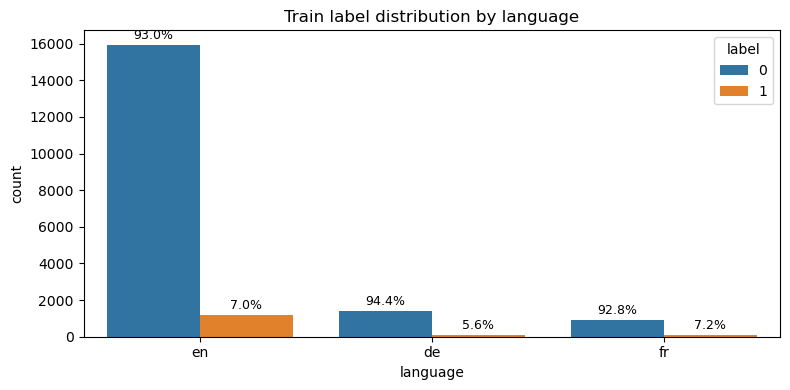

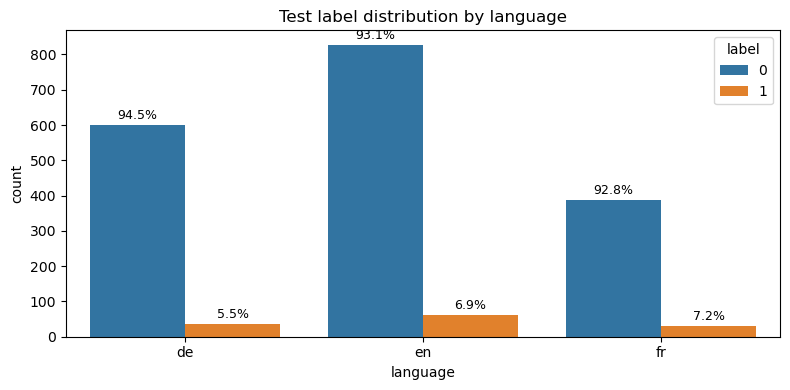

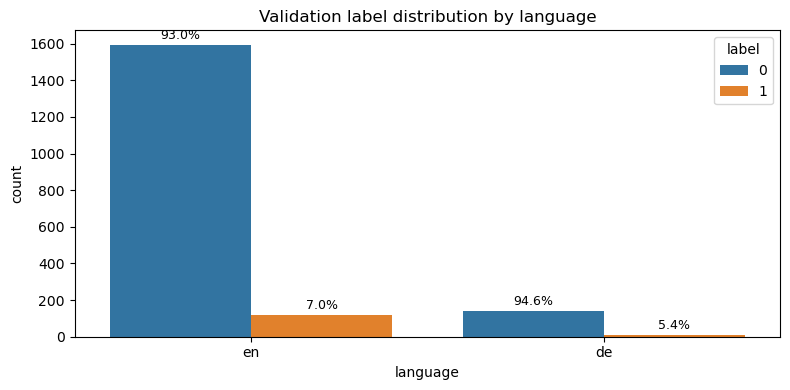

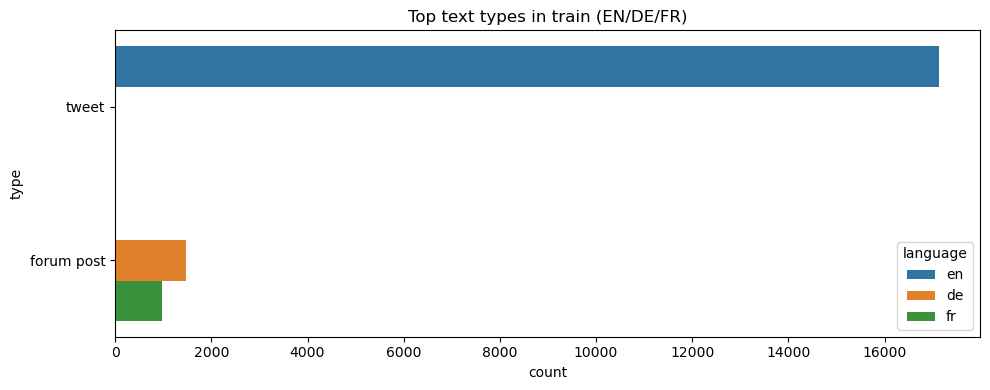

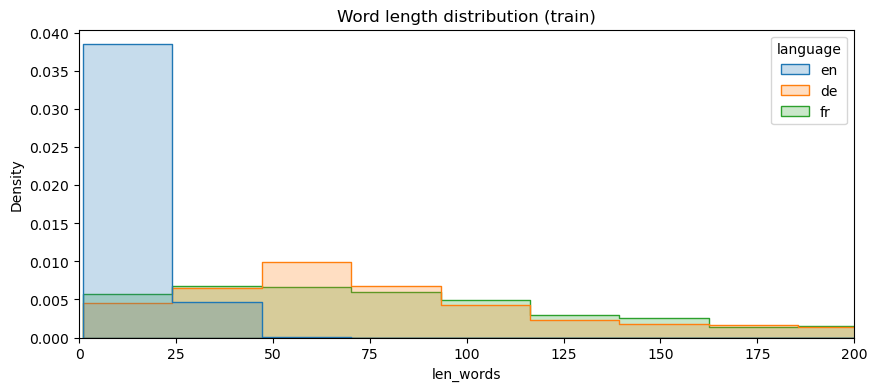

In [7]:
def describe_split(df: pd.DataFrame, name: str) -> pd.DataFrame:
    tmp = df.copy()
    tmp["len_chars"] = tmp["text"].astype(str).str.len()
    tmp["len_words"] = tmp["text"].astype(str).str.split().map(len)

    summary = (
        tmp.groupby("language")
        .agg(
            n=("id", "count"),
            pos_rate=("label", "mean"),
            avg_words=("len_words", "mean"),
            p95_words=("len_words", lambda s: float(np.percentile(s, 95))),
        )
        .sort_values("n", ascending=False)
    )
    summary.index.name = f"{name}_language"
    return summary

print("=== Train (filtered to EN/DE/FR) ===")
display(describe_split(train_df, "train"))

print("=== Test (dev-as-test, filtered to EN/DE/FR) ===")
display(describe_split(test_df, "test"))


def _label_dist_plot(df: pd.DataFrame, title: str):
    """Bar plot of label counts per language with percentage annotations."""
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.countplot(data=df, x="language", hue="label", ax=ax)
    ax.set_title(title)

    # Compute totals per language for percentage calculation
    lang_totals = df["language"].value_counts().to_dict()

    for container in ax.containers:
        for bar in container:
            count = int(bar.get_height())
            if count == 0:
                continue
            # Identify the language for this bar from its x position
            tick_idx = round(bar.get_x() + bar.get_width() / 2)
            lang = ax.get_xticklabels()[tick_idx].get_text() if tick_idx < len(ax.get_xticklabels()) else None
            # Fall back: match bar centre to tick positions
            if lang is None or lang not in lang_totals:
                xticks = ax.get_xticks()
                centre = bar.get_x() + bar.get_width() / 2
                closest = int(np.argmin(np.abs(np.array(xticks) - centre)))
                lang = ax.get_xticklabels()[closest].get_text()
            pct = 100 * count / lang_totals.get(lang, count)
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() + ax.get_ylim()[1] * 0.01,
                f"{pct:.1f}%",
                ha="center", va="bottom", fontsize=9,
            )

    plt.tight_layout()
    plt.show()


# Label distribution plots
_label_dist_plot(
    train_df[train_df["language"].isin(TRAIN_LANGS + [ZERO_SHOT_LANG])],
    "Train label distribution by language",
)
_label_dist_plot(test_df, "Test label distribution by language")
_label_dist_plot(val_en_de, "Validation label distribution by language")

# Type mix
plt.figure(figsize=(10, 4))
plot_df = train_df[train_df["language"].isin(TRAIN_LANGS + [ZERO_SHOT_LANG])]
order = plot_df["type"].value_counts().head(8).index
sns.countplot(data=plot_df[plot_df["type"].isin(order)], y="type", hue="language")
plt.title("Top text types in train (EN/DE/FR)")
plt.tight_layout()
plt.show()

# Length distributions
plt.figure(figsize=(10, 4))
plot_df = train_df[train_df["language"].isin(TRAIN_LANGS + [ZERO_SHOT_LANG])].copy()
plot_df["len_words"] = plot_df["text"].astype(str).str.split().map(len)
sns.histplot(data=plot_df, x="len_words", hue="language", bins=60, element="step", stat="density", common_norm=False)
plt.xlim(0, 200)
plt.title("Word length distribution (train)")
plt.show()


### Manual inspection across languages

The following cell samples a few **positive** and **negative** examples per language for manual inspection.
Look for:
- negation and sarcasm
- dosage/medical abbreviations
- implicit adverse events vs explicit side effects
- annotation ambiguity


In [8]:
def sample_examples(df: pd.DataFrame, lang: str, label: int, n: int = 5, seed: int = 42) -> pd.DataFrame:
    sub = df[(df["language"] == lang) & (df["label"] == label)].copy()
    if len(sub) == 0:
        return sub
    return sub.sample(n=min(n, len(sub)), random_state=seed)[["id", "language", "label", "type", "origin", "text"]]

for lang in ["en", "de", "fr"]:
    print("\n=====", lang.upper(), "(NEG) =====")
    display(sample_examples(train_df, lang, 0, n=5, seed=SEED))
    print("\n=====", lang.upper(), "(POS) =====")
    display(sample_examples(train_df, lang, 1, n=5, seed=SEED))



===== EN (NEG) =====


,id,language,label,type,origin,text
7587,en_9488,en,0,tweet,previous_SMM4H,Can off label use of #Letrozole in #PCOS be recommended? HTTPURL
14727,en_9279,en,0,tweet,previous_SMM4H,@USER d: do you need a lozenge? or maybe drink lukewarm water?
2092,en_2109,en,0,tweet,previous_SMM4H,without boniva sally would be just a mumbling pile of shattered bone. #blessed #oscars
10820,en_1057,en,0,tweet,previous_SMM4H,"(This morning's cocktail of meds: 150mg pregabalin, 40mg fluoxetine, 50mg losartan, 500mg amoxicillin, multivitamin. It's fun!)"
11955,en_11378,en,0,tweet,previous_SMM4H,Fibro Question: Who has been on the Drug Merry-Go Round? (Vicodin to Lyrica to Elavil to Lunesta to Cymbalta to Lexipro on and on.)



===== EN (POS) =====


,id,language,label,type,origin,text
19270,en_16052,en,1,tweet,previous_SMM4H,#restlesslegs #quetiapine
16755,en_10231,en,1,tweet,previous_SMM4H,tysabri bruises are the best HTTPURL
1590,en_9952,en,1,tweet,previous_SMM4H,@USER i know. i just realised with everything else - i haven't taken the sodding quetiapine yet!! wondered why i wasn't drowsy doh!
7042,en_4786,en,1,tweet,previous_SMM4H,vyvanse makes my brain crazier than it already is.
897,en_1080,en,1,tweet,previous_SMM4H,slept 11 hours last night on seroquel o.o



===== DE (NEG) =====


,id,language,label,type,origin,text
8924,de_1272,de,0,forum post,LREC2022,"Hallo @USER Viel Frauen hier im Forum haben eine Chemo bekommen, aber ich hab noch nie davon gehört, dass man danach Impfungen auffrischen oder wiederholen muss. Ich bin fest der Meinung, dass die Ärzte einen darauf hinweisen würden........aber naja, am besten du fragst deinen Arzt danach. Ich hab zwe wirklich gute Ärzte, die mehr als nur die normalen Untersuchungen machen, aber keiner hat etwas dazu gesagt. Was man aber machen sollte, sich im Herbsz gegen die Grippe impfen lassen, da man nach eine Chemo noch sehr wenig Abwehrstoffe hat. Ich wünsch dir alles Gute, viel Glück und ein langes Leben @USER"
8233,de_885,de,0,forum post,LREC2022,"Liebe @USER danke für deinen Bericht. Das ist manchmal wirklich ein wochenweiser Wechsel. Erst warens die <Finger, jetzt die Knie. Mal sehen was morgen ist.... Ich wünsche >Dir nochen einen schönen Sonntag Lg @USER"
1494,de_656,de,0,forum post,LREC2022,"Hallo ihe Lieben, nachdem es mir ein Tage wirklich richig gut ging, kamen ein paar Tage voller Stress auf mich zu - Geburtstag des Sohnes, Streitereien familienintern weil, mein eigener Geburtstag und wieder ein Jahr älter hat ich innerlich so aufgewühlt, dass ich nachts wachwerde und erst nach einer Stunde lesen wieder einschlafen kann. Heute Morgen dann, an meinem Geburtstag versuchte ich zarte Fühler nach dem eigentlich doch schönen Tag auszustrecken, doch ließ die innere Unruhe nicht nach. Als ich im Badezimmer das Waschbecken putzte, überkam mich plötzlich ein Schwindel wie ich ihn so nicht kennengelernt hatte..es zog mir regelrecht vom Hinterkopf hoch und ich dachte echt, dass ich vornüber ins Wachbecken kippe. Prompt meldete sich meine Panik, mein Puls schnellte hoch, Blutdruck trotz Pille war auf 160/100 und ich dachte, dass ich an meinem Geburtstag dahingerafft werde. Bin dann sicherheitshalber zum Arzt, der meinte es läge an meinem inneren Stress, solche Familienfeste können sich krass aufs Gemüt legen so man nicht stabil und entspannt ist. Ich solle mich entspannen und gab mir Globuli gegen den Stress und die Angst. Nun gehts mir wieder besser, Blutdruck normal und auch kein Schwindel mehr, doch steckt mir der Schreck noch in den Gliedern. Wann hört das nur auf. Liegts an meiner Dünnhäutigkeit die durch die WJ verursacht werden oder ist da was Organisches? Warum haben so viele Frauen Schwindelzustände in den WJ, was genau geschieht dann? Haben gleich ne kleine Kaffeerunde und ich hoffe, dass ich das gut überstehen werde... so ein Mist..positiv denken ist manchmal garnicht so leicht. LG @USER"
6046,de_982,de,0,forum post,LREC2022,"Das hat mich erschreckt: Gestern auf Sat3 kamen zwei Sendungen: Gefährliche Umwelthormone und Im Takt der Hormone. Vielleicht hat es jemand geschaut? Leider kann man die Sendung im Internet nicht noch mal schauen. Vor allem ging es um die Hormonwirkung von Stoffen, die sich im Plastik befinden. Allem voran Bisphenol A. Diese Stoffe docken an Östrogenrezeptoren an und verändern die körpereigene Produktion. Es wurden zahlreiche wissenschaftliche Versuche gezeigt und erklärt. Bisphenol A und andere hormonähnliche Stoffe in Kunststoff werden mit vielen Krankheiten in Verbindung gebracht. Auch mit verfrühten WJ. Aber auch mit Fettleibigkeit, Diabetes, Allergien, ADHS, Autismus, Unfruchtbarkeit, verminderter Intelligenz...etc. pp. Für Kinder sind die Folgen richtig schlimm!!!! Ich verzichte ja schon geraume Zeit (möglichst) auf Nahrung und Getränke in Plastikverpackungen, benutze keine Tupperdosen, Frischhaltefolie etc. und ich denke, es wäre einen Versuch wert, diese hormonähnlichen Stoffe in der Ernährung zu minimieren. Aber auch Thermopapiere: Faxe, Kassenbons, Parkzettel....enthalten hohe Werte von Bisphenol A und sie gelangen durch Anfassen in den Körper..... Hier ein link: <url> Wenn man googelt, findet man viele weitere Infos. Ich wünsche allen geplagten Frauen hier ein schönes Wochenende. Habe Urlaub und werde ab Sonntag 8 Tage un


===== DE (POS) =====


,id,language,label,type,origin,text
6427,de_497,de,1,forum post,SMM4H_24_de_test,"Hallo, @USER! Dasselbe Problem hatte ich auch, bin richtig davon überrannt worden. Psychische Probleme kannte ich bis dato gar nicht. Das war auch mit ein Grund, die HET abzusetzen, weil ich zuletzt überhaupt nicht mehr damit klar kam. Ich denke heute, dass es einfach daran lag, dass mein Gyn mich mit Östrogen vollgepumpt hat, obgleich meine Progesteronwerte seit Jahren im Keller waren. Die Ö-Werte waren unter der HET in den letzten Jahren immer schön im grünen Bereich, die P-Werte aber gleich 0, somit lag eine fette Östrogendominanz vor! Das Gleichgewicht unter den Hormonen fehlte und hat dafür gesorgt, dass ich richtig, richtig Probleme bekommen habe. Bin ja jetzt erst mit der P-Creme angefangen, und gestern hatte ich mal wieder einen kleinen Rückschlag, aber ich bin guter Dinge, dass es eigentlich nur besser werden kann, wenn das P-Depot erst einmal wieder aufgebaut wurde. Bevor Du jetzt mit der P-Creme loslegst, würde ich aber auf jeden Fall empfehlen, erst einmal Deine Hormonwerte ermitteln zu lassen. Aber nachdem, was Du jetzt geschrieben hast, gehe ich davon aus, dass Dein P-Spiegel ebenfalls im Keller ist, weil der Körper einfach zum Zeitpunkt der Menopause kein P mehr produziert, aber Ö ist immer noch in geringen Mengen vorhanden. Also lass Dich nicht unterkriegen. Wenn Du vor der Menopause keine psychischen Probleme hattest, warum dann auf einmal? Ich werde auch derzeit von körperlichen Problemen regelrecht überfahren. Manchmal kenne ich mich selbst nicht mehr wieder. Herzrythmusstörungen, Depri etc. etc., das sind alles Sachen, worüber ich früher nur gelesen und leise geschmunzelt habe. Ich kann mich noch daran erinnern, dass wir in jungen Jahren über ältere Damen, die völlig durch den Wind waren, nur gelacht haben und immer kam der Spruch: 'Ach, die ist bestimmt in den WJ'! Also Kopf hoch, bisher haben es noch alle überlebt! LG @USER"
46,de_935,de,1,forum post,SMM4H_24_de_train,"Hallo @USER, du brauchst dich doch nicht zu entschuldigen. Ich habe 2015 ganz kurz Hormone probiert, aber das war in der Phase, in der ich selbst noch sehr verunsichert war ob meine Symptome wirklich von den Wechseljahren kommen. Hatte Gynokadin Gel und Famenita, war nicht so toll. Danach Tabletten, bekam nur Blutungen und Schmerzen. Jetzt werde ich ein Kombi Hormonpflaster ausprobieren. Werde dir berichten. Hatte mir geschworen, nur mit AD da durchzugehen, da ich von Frauen gelesen habe , die nach Absetzen der Hormone wieder richtig schlimme Symptome bekommen haben. Die Probleme wurden nur hinausgezögert. Da mir das AD momentan nicht so hilft ( hoffe es kommt noch die Erhöhung ist ja erst 2 Wochen her) werde ich die Hormone zumindest probieren. In der Apotheke meinten sie vielleicht verstoffwechsle ich schnell und daher hat die ganz niedrige Dosis AD nicht so angeschlagen. Mein Wirkspiegel ( habe das testen lassen) war nach 12 Wochen noch im unteren Bereich. Nein, wir haben noch keine Ferien. Noch eine Woche! Geht es dir heute besser? Bei mir la la. Wurschtle mich so durch. liebe Grüße @USER"
4628,de_1176,de,1,forum post,SMM4H_24_de_train,"Als ich damals mal Opri probiert habe, stand ich völlig neben mir. So richtig benebelt. . . . Wie durch Watte durch den Tag. . . Durch die Dämpfung fährt ja auch der Blutdruck bisschen runter und dann noch ein Senker obendrauf? Wäre für mich eine Erklärung, das du so neben der Spur bist. . . Wechselwirkungen? Sprich Bitte mit der Ärztin. . . .LG"
6522,de_1124,de,1,forum post,SMM4H_24_de_train,"Macht euch alle keine Sorgen, ich habe nur durch ziemliche Schmerzen zur Zeit, weil sich die Muskeln immer so verkrampfen und die Schmerztabletten und Valium hauen mir die Schuhe weg. Ich melde mich aber auf jeden Fall, ich habe ja nun eure E-Mail-Adressen. Bitte, mach dir keine Sorgen. Gruß @USER"
3559,de_117,de,1,forum post,SMM4H_24_de_train,"Hallo @USER, habe die Cerazette nur 4 Wochen genommen und nach 1 Woche ebenfalls 2 Tage lei


===== FR (NEG) =====


,id,language,label,type,origin,text
18789,fr_157,fr,0,forum post,LREC2022,"Je viens de voir que tu as répondu à ce message et que tu veux savoir comment cela se manifeste chez moi . ça a commencé dans le dos avec des petits boutons, je trouve que le soutien-gorge et le t-shirt sont laxistes sur la peau, ça frotte et ça me brûle. une fois que ça a disparu dans le dos, ça brûle sur la poitrine et maintenant c'est reparti !"
9386,fr_932,fr,0,forum post,LREC2022,"Salut @USER ,c'est vrai qu'avec les changements hormonaux ou les traitements hormonaux, on peut aussi avoir une sorte de mue vocale et la voix devient plus grave et plus rauque. prenons ça calmement Bises @USER"
7564,fr_397,fr,0,forum post,LREC2022,"Bonjour tabouret de bar, nous pouvons très volontiers ouvrir un fil CMD. Oui, j'ai aussi des douleurs articulaires et musculaires. En ce moment, c'est très dur. Je suis actuellement de nouveau en traitement de physiothérapie. Comme tout mon dos est raide comme une planche, de la colonne cervicale jusqu'à l'articulation ISG. D'après les analyses de sang, je n'ai pas de carence en œstrogènes. Les médecins ne te prennent vraiment plus au sérieux. Ouvre le guide sur les CMD et tu trouveras peut-être d'autres personnes qui partagent ton avis. Bises @USER"
15758,fr_728,fr,0,forum post,LREC2022,Souhaite à ta chère @USER un bon rétablissement. Bises
16857,fr_793,fr,0,forum post,LREC2022,"Salut, c'est vraiment ennuyeux. Maintenant, tu as pris des vacances supplémentaires, je ne pense pas qu'une semaine suffise pour récupérer. En particulier, tu fais raffermir ta poitrine et ton ventre, non ? J'ai d'ailleurs un rendez-vous vendredi après-midi. J'espère que ça va durer. En tout cas, je te souhaite bonne chance. J'espère que tu t'en sortiras bien. Salutations :-)"



===== FR (POS) =====


,id,language,label,type,origin,text
5559,fr_575,fr,1,forum post,SMM4H_24_fr_test,"Bonjour, j'ai commencé à utiliser Fumaderm il y a environ un an et demi. Le succès a été incroyable, mon psoriasis a complètement disparu. Entre-temps, la dermatologue m'a réduit à une dose d'un comprimé environ cinq jours sur sept de la semaine. Les effets secondaires ont été et restent très limités pour moi. Je n'ai pas du tout eu de maux d'estomac, ni de diarrhée significative. Seulement, les jours de prise, j'ai généralement une poussée de chaleur d'environ 20 minutes. C'est désagréable, mais sans commune mesure avec l'effet positif du produit. Mes valeurs sanguines se sont même améliorées au fil du temps. Salutations @USER."
175,fr_191,fr,1,forum post,SMM4H_24_fr_test,"Salut les amis, j'ai les yeux très secs depuis des années, puis le nez est venu s'ajouter et maintenant la bouche/le pharynx/les bronches aussi. Malheureusement, l'opipramol a aggravé la situation. C'est pourquoi j'ai acheté un gel hydratant (Aldiamed, flacon pulvérisateur) pour plus de 8 €. Je n'avais pas vraiment réalisé que l'ingrédient actif était un édulcorant - et je n'utilise pas d'édulcorants non plus. Maintenant, je sais pourquoi je ne le ferai pas à l'avenir : le gel était tellement sucré que j'étais complètement dégoûtée, la salive s'accumulait comme si on allait vomir. Malgré cela, la bouche était toujours sèche peu de temps après et une sensation rugueuse s'est ajoutée sur la langue (c'est également indiqué dans la notice). J'ai donc jeté le gel ... Maintenant, j'ai un petit vaporisateur en plastique vide pour 8 €... comme c'est gentil. Alors si l'une d'entre vous trouve quelque chose d'absolument neutre au niveau du goût, n'hésite pas à me le faire savoir. ( Ah oui - mon pharmacien a dit qu'il vaporisait aussi le spray nasal (sel d'Ems) dans sa bouche/gorge ... c'est ce que je fais maintenant avant de m'endormir). Amitiés @USER"
11676,fr_626,fr,1,forum post,SMM4H_24_fr_test,"Salut @USER Avec les suppositoires hormonaux, c'est très pratique ! On pense que si on les prend, on reste jeune et en forme ! Une erreur ! Ils passent immédiatement dans le sang et ont plusieurs effets secondaires. A cause des suppositoires, qui sont censées favoriser la circulation sanguine dans le vagin, j'ai pris beaucoup de poids (20 kilos de trop), j'ai eu beaucoup d'appetit, je n'avais plus d'énergie et mes yeux et mon visage étaient gonflés, comme si j'étais alcoolique. Sans oublier que j'avais aussi un gros myome. J'ai moi-même arrêté d'en prendre et maintenant je n'ai plus de myome, des yeux et un visage normaux et je suis comme toujours en forme, mince et pleine d'énergie. Utilise de l'huile d'amande bio !!!!! en cas de sécheresse vaginale. Mieux vaut donc ne pas la prendre ! Les gynécologues et les pharmacies font de grosses affaires et gagnent beaucoup d'argent avec ça. Les hormones pendant la ménopause NON, MERCI !"
674,fr_151,fr,1,forum post,SMM4H_24_fr_test,"Salut tout le monde, alors la protection de l'estomac m'intéresse aussi. Je prends de la sulfasalazine depuis quelques jours maintenant, je ne ressens qu'une fatigue extrême, mais pas de nausées jusqu'à présent, je dois juste faire des rots très souvent. Faut-il prendre un protecteur d'estomac ? On ne m'en a pas prescrit, on ne m'en a pas parlé non plus. Amitiés @USER"
14051,fr_293,fr,1,forum post,SMM4H_24_fr_test,"Salut @USER, j'ai déjà pris quelques globules, car j'ai suivi un long traitement chez une naturopathe. Mes hormones sont toutes au plus bas, il reste encore un peu d'oestrogène (15) et je transpire plus, je suis en post-ménopause, c'est-à-dire que je n'ai pas eu de règles depuis plus de 3 ans. Mais je veux être satisfaite, c'était bien pire avant, je suis sûre que ça va s'arranger, c'est ce que ma gynécologue m'a dit l'autre jour. Je ne supporte pas les hormones chimiques et naturelles comme le Gynokadin et l'Utrogest, après tellement d'essais, juste pour info. Bonne soirée, salutations, @USER."



* Much smaller dataset size for DE and especially FR
* English samples have much fewer words on average than German and French (X vs forums)
* TODO: Address class imbalance:

1. Changes During Training (Algorithm-Level)
    - Weighted Loss Functions: Modify your loss function to penalize misclassifications of the minority class more heavily.
    - Class Weights: Assign a higher weight to the positive class in the Binary Cross Entropy loss.
    - Focal Loss: Use Focal Loss to down-weight "easy" majority examples and focus training on "hard" minority examples.
    - Threshold Moving: Instead of the default 0.5 probability threshold, lower the threshold for the positive class to increase recall.
    - Bias Initialization: Initialize the final layer's bias to 
 to prevent the model from spending initial epochs learning that the majority class is simply more frequent. 
2. Changes to Data (Data-Level)
    - Resampling:
        - Random Undersampling: Remove majority class examples to balance the ratio. While fast, it risks losing valuable information.
        - Random Oversampling: Duplicate minority examples. This is simple but can lead to overfitting.
    - Text Augmentation: Use NLP-specific techniques like Back-Translation (translating text to another language and back) or Synonym Replacement to create diverse new samples for the 0.5% minority class. 
3. Changes During Evaluation
    - Accuracy is misleading in this scenario (a model predicting "Negative" 100% of the time would achieve 99.5% accuracy). Instead, use: 
        - Precision-Recall (PR) Curve & AUPRC: Generally superior to ROC curves for extreme imbalance as it does not factor in True Negatives.
        - F1-Score. Use F1 to balance Precision and Recall, or F2 if missing a positive case (Recall) is more costly than a false alarm.
        - Confusion Matrix: Always inspect the raw counts of True Positives and False Negatives to understand the "cost" of the imbalance. 

## Task 1.1 (continued) — EN→FR translation (6000 EN samples, stratified by label)

We create a subset of **exactly 6000** English training examples, stratified by ADE label, translate them to French using an **offline MT model** (`Helsinki-NLP/opus-mt-en-fr`), and cache results to disk so reruns are fast.


Before translation we **strip `#` from hashtags** so that MarianMT translates the underlying words (e.g. `#prostatitis` → `prostatitis`) instead of passing them through verbatim.

In [13]:
from transformers import MarianMTModel, MarianTokenizer
from tqdm.auto import tqdm

TRANSLATIONS_CACHE = ARTIFACTS_DIR / f"translations_en_fr_{TRANSLATE_N}_seed{SEED}.csv"


def stratified_sample_en(df: pd.DataFrame, n: int, seed: int) -> pd.DataFrame:
    """Sample n English examples **preserving the natural label distribution**.

    Previous version targeted 50/50 balance, which inflated the positive rate
    from ~7% to ~36% and caused the translation-trained FR model to massively
    over-predict positives at test time (where the positive rate is ~7%).
    """
    en = df[(df["language"] == "en")].copy().reset_index(drop=True)
    if len(en) <= n:
        return en.sample(frac=1.0, random_state=seed).reset_index(drop=True)

    # Stratified sample that preserves the original label proportions
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=n, random_state=seed)
    _, idx_sample = next(splitter.split(en, en["label"]))
    out = en.iloc[idx_sample].sample(frac=1.0, random_state=seed).reset_index(drop=True)
    return out


HASHTAG_RE = re.compile(r"#(\w+)")


def _strip_hashtags_for_translation(text: str) -> str:
    """Strip '#' from hashtags so MarianMT translates the underlying words.

    E.g. '#prostatitis' → 'prostatitis', '#CyberSecurity' → 'CyberSecurity'.
    Without this, MarianMT treats hashtags as opaque tokens and leaves them
    untranslated in the French output.
    """
    return HASHTAG_RE.sub(r"\1", text)


def translate_en_to_fr(texts: List[str], model_name: str, batch_size: int = 16) -> List[str]:
    tok = MarianTokenizer.from_pretrained(model_name)
    model = MarianMTModel.from_pretrained(model_name)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    # Strip hashtags before translation so words get translated
    texts = [_strip_hashtags_for_translation(t) for t in texts]

    outputs: List[str] = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Translating EN→FR"):
        batch = texts[i : i + batch_size]
        enc = tok(batch, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LENGTH).to(device)
        with torch.no_grad():
            gen = model.generate(
                **enc,
                num_beams=4,
                max_new_tokens=MAX_LENGTH,
            )
        out = tok.batch_decode(gen, skip_special_tokens=True)
        outputs.extend(out)

    return outputs


def build_or_load_translations() -> pd.DataFrame:
    if TRANSLATIONS_CACHE.exists():
        print("Loading cached translations from:", TRANSLATIONS_CACHE)
        cached = pd.read_csv(TRANSLATIONS_CACHE)
        return cached

    en_subset = stratified_sample_en(train_en_de, n=TRANSLATE_N, seed=SEED)
    print("Sampled EN subset for translation:")
    display(en_subset["label"].value_counts())

    fr_texts = translate_en_to_fr(en_subset["text"].tolist(), model_name=TRANSLATION_MODEL_NAME, batch_size=16)

    out = en_subset.copy()
    out["text_en"] = out["text"]
    out["text"] = fr_texts
    out["language"] = "fr"
    out["translation_source"] = "en"
    out["translation_model"] = TRANSLATION_MODEL_NAME

    TRANSLATIONS_CACHE.parent.mkdir(exist_ok=True)
    out.to_csv(TRANSLATIONS_CACHE, index=False)
    print("Saved translations to:", TRANSLATIONS_CACHE)
    return out


fr_translated_train = build_or_load_translations()
print("Translated train rows:", len(fr_translated_train))
print(fr_translated_train[["language", "translation_source"]].drop_duplicates())

display(fr_translated_train[["label"]].value_counts())

# Show a small, balanced sample for manual inspection (EN original vs FR translation)
if "text_en" not in fr_translated_train.columns:
    print("Warning: 'text_en' column not found in translation cache; side-by-side view may be incomplete.")
    fr_translated_train = fr_translated_train.copy()
    fr_translated_train["text_en"] = ""

def _sample_translations_side_by_side(df: pd.DataFrame, label: int, n: int = 5, seed: int = 42) -> pd.DataFrame:
    sub = df[df["label"] == label].copy()
    if len(sub) == 0:
        return sub
    sub = sub.sample(n=min(n, len(sub)), random_state=seed)
    view_cols = [c for c in ["id", "label", "text_en", "text"] if c in sub.columns]
    view = sub[view_cols].rename(columns={"text_en": "EN", "text": "FR"})
    return view.reset_index(drop=True)

print("\nSample translations (5 NEG, 5 POS) — EN vs FR side-by-side")
display(_sample_translations_side_by_side(fr_translated_train, label=0, n=30, seed=SEED))
display(_sample_translations_side_by_side(fr_translated_train, label=1, n=30, seed=SEED))

Sampled EN subset for translation:


label
0    5580
1     420
Name: count, dtype: int64

Loading weights: 100%|██████████| 258/258 [00:00<00:00, 2246.00it/s, Materializing param=model.shared.weight]                                  
The tied weights mapping and config for this model specifies to tie model.shared.weight to model.decoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie model.shared.weight to model.encoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
Translating EN→FR: 100%|██████████| 375/375 [04:14<00:00,  1.47it/s]

Saved translations to: /home/mandado/repos/advanced nlp/smm4h2026/artifacts/translations_en_fr_6000_seed42.csv
Translated train rows: 6000
  language translation_source
0       fr                 en


label
0        5580
1         420
Name: count, dtype: int64


Sample translations (5 NEG, 5 POS) — EN vs FR side-by-side


,id,label,EN,FR
0,en_15060,0,@USER The Zyprexa would be a good med to get on consistently. As an atypical anti-psychotic it's good for the manic type symptoms,"@USER Le Zyprexa serait un bon médicament pour se mettre à l'aise. En tant qu'antipsychotique atypique, il est bon pour les symptômes de type maniaque"
1,en_1138,0,I could make a Boniva joke but Sally Field actually just looks great #Oscars,"Je pourrais faire une blague de Boniva, mais Sally Field a l'air d'être un super Oscar."
2,en_11611,0,Unbelievable how research has discovered taking thalidomide affected the babies body during certain days of pregnancy #Thalidomide,Incroyable comment la recherche a découvert la prise de thalidomide a affecté le corps des bébés pendant certains jours de la grossesse Thalidomide
3,en_3272,0,We’re completely alone in the bar thanks to the bartender’s nicotine addiction. Making dares to each other to go refill our beer pitcher.,Nous sommes complètement seuls dans le bar grâce au barman de la dépendance à la nicotine. Faire ose les uns aux autres pour aller remplir notre pichet à bière.
4,en_9428,0,"Starships, Sabers, and Scoundrels Episode 58: Padawan Lost and Found. We're talking The Clone Wars, the Thrawn cover, and George's plans for the sequels. Where is Taxus? HTTPURL HTTPURL","Starships, Sabers, and Scoundrels Episode 58: Padawan Lost and Found. Nous parlons des Clone Wars, de la couverture Thrawn, et des plans de George pour les suites. Où est Taxus? HTTPURL HTTPURL"
5,en_6158,0,@USER @USER butting in....Cymbalta is no joke! I hated that medication...Once and NEVER again!,@USER @USER butting in....Cymbalta n'est pas une blague! Je détestais ce médicament... une fois et jamais!
6,en_13048,0,"Watching hoarders and the lady is depressed and my mom goes ""she needs cymbalta"" #jennisms @USER","Regarder les voyous et la dame est déprimée et ma mère dit ""elle a besoin de cymbalta"" jennismes @USER"
7,en_8629,0,@USER have u took something ? #olanzapine ? #clozapine? #valium ?,@USER ont pris quelque chose ? olanzapine ? clozapine ? valium ?
8,en_1566,0,@USER CAN WE?? ill bring the miralax,@USER PEUT-ON?? mal apporter le miralax
9,en_11141,0,boniva is poison. do not take it! research it first! you are your own best advocate.. these docs do not do clinical trials. fda...hah!,Boniva est poison. ne le prenez pas! la recherche d'abord! vous êtes votre propre meilleur avocat.. ces docs ne font pas d'essais cliniques. fda...hah!


,id,label,EN,FR
0,en_2500,1,"Hmm, interesting. I may have been undergoing Baclofen withdrawal hence the anxiety for the past few months… #hypochondria","J'ai peut-être subi un retrait de Baclofen, d'où l'anxiété des derniers mois... l'hypochondrie."
1,en_4542,1,"@USER nope, was on #enbrel 5yrs &amp; had to get off due to unrelenting flare. been on #humira since dec 2012. #rheum","@USER nope, était sur enbrel 5yrs &amp; a dû descendre en raison d'une éruption sans relâche. être sur humira depuis décembre 2012. rheum"
2,en_2984,1,"@USER olanzapine is amazing srsly, the dreams are immense, no addiction, its gorgeous, like brave new world soma to me","@USER olanzapine est incroyable srly, les rêves sont immenses, pas de dépendance, son magnifique, comme brave nouveau monde soma pour moi"
3,en_11440,1,@USER i take olanzapine and have a permanent dry mouth what can i do to help it,@USER je prends de l'olanzapine et j'ai une bouche sèche permanente que puis-je faire pour l'aider
4,en_15393,1,"@USER bloody zombie I also take venlafaxine thats for cronic depression bipolar is a difficult illness to deal with, both for the","@USER zombie sanglant je prends aussi venlafaxine thats pour la dépression cronique bipolaire est une maladie difficile à traiter, à la fois pour le"
5,en_6215,1,my creativity was blocked by lithium and prozac and wellbutrin and paxil and zoloft and effexor and lexapro and cymbalta and abilify-,ma créativité a été bloquée par le lithium et le prozac et la puitsbutrin et paxil et zoloft et effexor et lexapro et cymbalta et abilify-
6,en_2063,1,nicotine withdrawals. #needasmoke,Sevrages de nicotine. besoin d'asmoke
7,en_4588,1,meds paranoia cos my leg is itching #lamictal #bipolar,meds paranoïa parce que ma jambe démange lamictal bipolaire
8,en_4828,1,"Damn i need to sleep, fucken vyvanse","Merde, j'ai besoin de dormir, putain de Vyvanse"
9,en_15934,1,@USER i hav to come of the duloxetine immediately as i hav a terrible rash because of it! had the rash 2 weeks,@USER i hav à venir de la duloxétine immédiatement comme j'ai eu une éruption terrible à cause de cela! eu l'éruption 2 semaines


Translation analysis:
- Even after stripping `#`, hashtags are not translated when they are sentences without spaces (e.g. `cantsleep` → `cantsleep` in FR instead of `nepeutpasdormir`).

## Task 1.3 — Modeling (XLM-R classifier) + Task 1.4 — Evaluation and error analysis

We use the same training loop across setups via Hugging Face `Trainer`.

Setups:
1) **Monolingual EN**: train on EN only, evaluate on EN test
2) **Monolingual DE**: train on DE only, evaluate on DE test
3) **Multilingual EN+DE**: train on EN+DE, evaluate on EN test + DE test and **zero-shot FR test**
4) **Translation-trained FR**: train on EN→FR translated subset, evaluate on FR test

All setups share the same backbone via `MODEL_NAME`.


In [15]:
import gc
import inspect

def df_to_hf_dataset(df: pd.DataFrame) -> Dataset:
    cols = ["id", "text", "label", "language", "type", "origin"]
    cols = [c for c in cols if c in df.columns]
    return Dataset.from_pandas(df[cols], preserve_index=False)

def tokenize_dataset(ds: Dataset, tokenizer: AutoTokenizer, max_length: int) -> Dataset:
    def _tok(batch):
        return tokenizer(batch["text"], truncation=True, max_length=max_length)
    keep_cols = {"label", "language", "id", "type", "origin", "text"}
    drop_cols = [c for c in ds.column_names if c not in keep_cols]
    return ds.map(_tok, batched=True, remove_columns=drop_cols)

def compute_metrics(eval_pred):
    # HF may pass an EvalPrediction or a tuple depending on version
    if hasattr(eval_pred, "predictions") and hasattr(eval_pred, "label_ids"):
        logits = eval_pred.predictions
        labels = eval_pred.label_ids
    else:
        logits, labels = eval_pred


    probs = torch.softmax(torch.tensor(logits), dim=-1).numpy()
    preds = probs.argmax(axis=-1)


    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary", zero_division=0)
    acc = accuracy_score(labels, preds)
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

def _ta_signature_params() -> Dict[str, inspect.Parameter]:
    return inspect.signature(TrainingArguments.__init__).parameters

def _training_args_kwargs(
    run_name: str,
    out_dir: Path,
    per_device_train_batch_size: int = BATCH_SIZE,
    per_device_eval_batch_size: int = BATCH_SIZE,
    gradient_accumulation_steps: int = 1,
    ) -> Dict:
    params = _ta_signature_params()
    kwargs = {
        "output_dir": str(out_dir),
        "run_name": run_name,
        "seed": SEED,
        "data_seed": SEED,
        "learning_rate": LR,
        "weight_decay": WEIGHT_DECAY,
        "per_device_train_batch_size": per_device_train_batch_size,
        "per_device_eval_batch_size": per_device_eval_batch_size,
        "gradient_accumulation_steps": gradient_accumulation_steps,
        "num_train_epochs": 1 if DEBUG_SMALL else EPOCHS,
        "load_best_model_at_end": True,
        "metric_for_best_model": "f1",
        "greater_is_better": True,
        "logging_steps": 50,
        "report_to": [],
        "fp16": torch.cuda.is_available(),
    }
    if "evaluation_strategy" in params:
        kwargs["evaluation_strategy"] = "epoch"
    else:
        kwargs["eval_strategy"] = "epoch"
    kwargs["save_strategy"] = "epoch"
    if "overwrite_output_dir" in params:
        kwargs["overwrite_output_dir"] = True
    if "gradient_accumulation_steps" not in params:
        kwargs.pop("gradient_accumulation_steps", None)
    return kwargs

def _inference_args(out_dir: Path) -> TrainingArguments:
    params = _ta_signature_params()
    kwargs: Dict = {
        "output_dir": str(out_dir),
        "per_device_eval_batch_size": BATCH_SIZE,
        "report_to": [],
    }
    # Ensure inference doesn't require eval_dataset and doesn't touch GPU
    if "evaluation_strategy" in params:
        kwargs["evaluation_strategy"] = "no"
    else:
        kwargs["eval_strategy"] = "no"
    kwargs["save_strategy"] = "no"
    if "no_cuda" in params:
        kwargs["no_cuda"] = True
    if "use_cpu" in params:
        kwargs["use_cpu"] = True
    return TrainingArguments(**kwargs)

def _free_cuda_memory():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

def _is_oom_error(exc: BaseException) -> bool:
    name = exc.__class__.__name__.lower()
    msg = str(exc).lower()
    return "outofmemory" in name or "cuda out of memory" in msg or "out of memory" in msg

def train_model(
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    run_name: str,
    model_name: str = MODEL_NAME,
    max_length: int = MAX_LENGTH,
    force_retrain: bool = False,
    ) -> Tuple[Trainer, AutoTokenizer]:
    out_dir = ARTIFACTS_DIR / "runs" / run_name
    out_dir.mkdir(parents=True, exist_ok=True)
    best_dir = out_dir / "best_model"


    def _build_inference_trainer(tok: AutoTokenizer) -> Trainer:
        model = AutoModelForSequenceClassification.from_pretrained(str(best_dir))
        model.to("cpu")
        return Trainer(
            model=model,
            args=_inference_args(out_dir),
            data_collator=DataCollatorWithPadding(tokenizer=tok),
            compute_metrics=compute_metrics,
        )

    # If already trained and not forcing retrain, load and skip retraining
    if best_dir.exists() and not force_retrain:
        tokenizer = AutoTokenizer.from_pretrained(str(best_dir), use_fast=True)
        _free_cuda_memory()
        print(f"Loaded existing model from: {best_dir}")
        return _build_inference_trainer(tokenizer), tokenizer

    # Clear previous checkpoint when retraining
    if best_dir.exists() and force_retrain:
        import shutil
        shutil.rmtree(best_dir)
        print(f"Cleared previous best_model for retrain: {best_dir}")


    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


    train_ds = tokenize_dataset(df_to_hf_dataset(train_df), tokenizer, max_length)
    val_ds = tokenize_dataset(df_to_hf_dataset(val_df), tokenizer, max_length)


    candidate_bs = [BATCH_SIZE, max(1, BATCH_SIZE // 2), max(1, BATCH_SIZE // 4)]
    candidate_bs = sorted(set(candidate_bs), reverse=True)


    last_exc: Optional[BaseException] = None
    for bs in candidate_bs:
        grad_acc = max(1, math.ceil(BATCH_SIZE / bs))
        _free_cuda_memory()


        model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=2,
        )


        if torch.cuda.is_available():
            try:
                model.gradient_checkpointing_enable()
                if hasattr(model.config, "use_cache"):
                    model.config.use_cache = False
            except Exception:
                pass


        args = TrainingArguments(
            **_training_args_kwargs(
                run_name=run_name,
                out_dir=out_dir,
                per_device_train_batch_size=bs,
                per_device_eval_batch_size=bs,
                gradient_accumulation_steps=grad_acc,
            )
        )


        trainer = Trainer(
            model=model,
            args=args,
            train_dataset=train_ds,
            eval_dataset=val_ds,
            data_collator=data_collator,
            compute_metrics=compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=EARLY_STOPPING_PATIENCE)],
        )


        try:
            trainer.train()
            trainer.save_model(str(best_dir))
            tokenizer.save_pretrained(str(best_dir))


            # Drop training graph + optimizer state ASAP (critical for small GPUs)
            try:
                del trainer
                del model
            except Exception:
                pass
            _free_cuda_memory()


            if bs != BATCH_SIZE:
                print(f"Trained with reduced per-device batch size={bs} (grad_acc={grad_acc})")


            return _build_inference_trainer(tokenizer), tokenizer
        except BaseException as exc:
            last_exc = exc
            if _is_oom_error(exc):
                try:
                    del trainer
                    del model
                except Exception:
                    pass
                _free_cuda_memory()
                continue
            raise
    if last_exc is not None:
        raise last_exc
    raise RuntimeError("Training failed for unknown reasons")

def predict_proba(trainer: Trainer, tokenizer: AutoTokenizer, df: pd.DataFrame, max_length: int = MAX_LENGTH) -> np.ndarray:
    ds = tokenize_dataset(df_to_hf_dataset(df), tokenizer, max_length)
    preds = trainer.predict(ds)
    logits = preds.predictions
    probs = torch.softmax(torch.tensor(logits), dim=-1).numpy()
    return probs

def evaluate_split(trainer: Trainer, tokenizer: AutoTokenizer, df: pd.DataFrame, lang: str, name: str, max_length: int = MAX_LENGTH) -> Dict:
    sub = df[df["language"] == lang].copy().reset_index(drop=True)
    if len(sub) == 0:
        return {"name": name, "lang": lang, "n": 0}


    probs = predict_proba(trainer, tokenizer, sub, max_length=max_length)
    pred = probs.argmax(axis=-1)
    y = sub["label"].values


    precision, recall, f1, _ = precision_recall_fscore_support(y, pred, average="binary", zero_division=0)
    acc = accuracy_score(y, pred)
    cm = confusion_matrix(y, pred)


    return {
        "name": name,
        "lang": lang,
        "n": len(sub),
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": cm,
        "_df": sub,
        "_probs": probs,
        "_pred": pred,
    }

def show_confusion(cm: np.ndarray, title: str):
    plt.figure(figsize=(3.5, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(title)
    plt.xlabel("Pred")
    plt.ylabel("Gold")
    plt.show()

### Train: Monolingual EN and DE

Training uses `train_en_de` / `val_en_de` but filtered per-language.


In [18]:
def filter_lang(df: pd.DataFrame, lang: str) -> pd.DataFrame:
    return df[df["language"] == lang].copy().reset_index(drop=True)

# Optionally shrink for debugging
if DEBUG_SMALL:
    train_en = filter_lang(train_en_de, "en").sample(n=min(800, len(filter_lang(train_en_de, "en"))), random_state=SEED)
    val_en = filter_lang(val_en_de, "en").sample(n=min(200, len(filter_lang(val_en_de, "en"))), random_state=SEED)
    train_de = filter_lang(train_en_de, "de").sample(n=min(800, len(filter_lang(train_en_de, "de"))), random_state=SEED)
    val_de = filter_lang(val_en_de, "de").sample(n=min(200, len(filter_lang(val_en_de, "de"))), random_state=SEED)
else:
    train_en = filter_lang(train_en_de, "en")
    val_en = filter_lang(val_en_de, "en")
    train_de = filter_lang(train_en_de, "de")
    val_de = filter_lang(val_en_de, "de")

print("EN train/val:", len(train_en), len(val_en))
print("DE train/val:", len(train_de), len(val_de))

trainer_en, tok_en = train_model(train_en, val_en, run_name="monolingual_en")
trainer_de, tok_de = train_model(train_de, val_de, run_name="monolingual_de")


EN train/val: 15415 1713
DE train/val: 1334 148
Loaded existing model from: /home/mandado/repos/advanced nlp/smm4h2026/artifacts/runs/monolingual_en/best_model


Loading weights: 100%|██████████| 201/201 [00:00<00:00, 2071.78it/s, Materializing param=roberta.encoder.layer.11.output.dense.weight]              


Loaded existing model from: /home/mandado/repos/advanced nlp/smm4h2026/artifacts/runs/monolingual_de/best_model


Loading weights: 100%|██████████| 201/201 [00:00<00:00, 2078.52it/s, Materializing param=roberta.encoder.layer.11.output.dense.weight]              


### Train: Multilingual EN+DE

Train on EN+DE jointly, validate on EN+DE joint validation.


In [19]:
if DEBUG_SMALL:
    train_multi = train_en_de.sample(n=min(1600, len(train_en_de)), random_state=SEED)
    val_multi = val_en_de.sample(n=min(400, len(val_en_de)), random_state=SEED)
else:
    train_multi = train_en_de
    val_multi = val_en_de

print("Multilingual train/val:", len(train_multi), len(val_multi))

trainer_multi, tok_multi = train_model(train_multi, val_multi, run_name="multilingual_en_de")


Multilingual train/val: 16749 1861
Loaded existing model from: /home/mandado/repos/advanced nlp/smm4h2026/artifacts/runs/multilingual_en_de/best_model


Loading weights: 100%|██████████| 201/201 [00:00<00:00, 2013.73it/s, Materializing param=roberta.encoder.layer.11.output.dense.weight]              


### Train: Translation-trained FR (EN→FR translated train)

Train a classifier on the translated French training subset and evaluate on **native French test**.


In [16]:
# Split translated FR train into train/val (stratified by label)
fr_strat = fr_translated_train["label"].astype(str)
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=SEED)
idx_tr, idx_va = next(splitter.split(fr_translated_train, fr_strat))
fr_train = fr_translated_train.iloc[idx_tr].reset_index(drop=True)
fr_val = fr_translated_train.iloc[idx_va].reset_index(drop=True)

if DEBUG_SMALL:
    fr_train = fr_train.sample(n=min(800, len(fr_train)), random_state=SEED)
    fr_val = fr_val.sample(n=min(200, len(fr_val)), random_state=SEED)

print("FR translated train/val:", len(fr_train), len(fr_val))

trainer_fr_trans, tok_fr_trans = train_model(fr_train, fr_val, run_name="translation_trained_fr", force_retrain=True)


FR translated train/val: 5400 600
Cleared previous best_model for retrain: /home/mandado/repos/advanced nlp/smm4h2026/artifacts/runs/translation_trained_fr/best_model


Loading weights: 100%|██████████| 197/197 [00:00<00:00, 1967.84it/s, Materializing param=roberta.encoder.layer.11.output.dense.weight]              
XLMRobertaForSequenceClassification LOAD REPORT from: xlm-roberta-base
Key                         | Status     | 
----------------------------+------------+-
lm_head.bias                | UNEXPECTED | 
lm_head.dense.weight        | UNEXPECTED | 
lm_head.layer_norm.bias     | UNEXPECTED | 
lm_head.dense.bias          | UNEXPECTED | 
roberta.pooler.dense.bias   | UNEXPECTED | 
lm_head.layer_norm.weight   | UNEXPECTED | 
roberta.pooler.dense.weight | UNEXPECTED | 
classifier.dense.weight     | MISSING    | 
classifier.out_proj.bias    | MISSING    | 
classifier.out_proj.weight  | MISSING    | 
classifier.dense.bias       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Con

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.258609,0.251272,0.930000,0.000000,0.000000,0.000000
2,0.260636,0.252168,0.930000,0.000000,0.000000,0.000000
3,0.250663,0.260696,0.930000,0.000000,0.000000,0.000000
4,0.294663,0.253691,0.930000,0.000000,0.000000,0.000000


Writing model shards: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]
There were missing keys in the checkpoint model loaded: ['roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.output.LayerNorm.weight', 'roberta.encoder.layer.0.output.LayerNorm.bias', 'roberta.encoder.layer.1.attention.output.LayerNorm.weight', 'roberta.encoder.layer.1.attention.output.LayerNorm.bias', 'roberta.encoder.layer.1.output.LayerNorm.weight', 'roberta.encoder.layer.1.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.output.LayerNorm.weight', 'roberta.encoder.layer.2.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.3.attention.output.LayerNorm.weight', 'roberta.encoder.layer.3.attention.output.LayerNorm.bias', 'roberta.encoder.la

### Evaluate all setups (per language)

We report metrics on the dev-as-test set for EN/DE/FR.


Map: 100%|██████████| 888/888 [00:00<00:00, 61979.63 examples/s]


Map: 100%|██████████| 418/418 [00:00<00:00, 13855.50 examples/s]


Map: 100%|██████████| 634/634 [00:00<00:00, 17088.03 examples/s]


Map: 100%|██████████| 418/418 [00:00<00:00, 14883.14 examples/s]


Map: 100%|██████████| 888/888 [00:00<00:00, 63988.97 examples/s]


Map: 100%|██████████| 634/634 [00:00<00:00, 17230.20 examples/s]


Map: 100%|██████████| 418/418 [00:00<00:00, 15666.19 examples/s]


Map: 100%|██████████| 418/418 [00:00<00:00, 16350.54 examples/s]


,name,lang,n,accuracy,precision,recall,f1
5,multi_en_de,de,634,0.925868,0.392857,0.628571,0.483516
2,mono_de,de,634,0.944795,0.000000,0.000000,0.000000
4,multi_en_de,en,888,0.961712,0.745455,0.672131,0.706897
0,mono_en,en,888,0.950450,0.654545,0.590164,0.620690
6,multi_en_de,fr,418,0.777512,0.205607,0.733333,0.321168
1,mono_en_zero_shot_fr,fr,418,0.755981,0.108696,0.333333,0.163934
3,mono_de_zero_shot_fr,fr,418,0.928230,0.000000,0.000000,0.000000
7,translation_trained_fr,fr,418,0.928230,0.000000,0.000000,0.000000


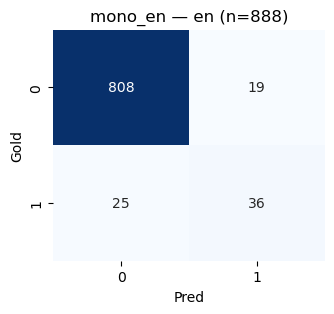

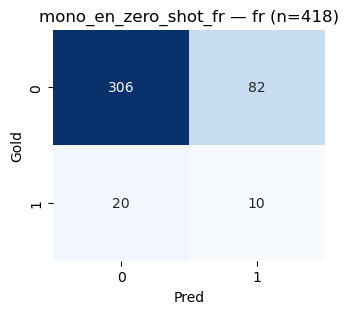

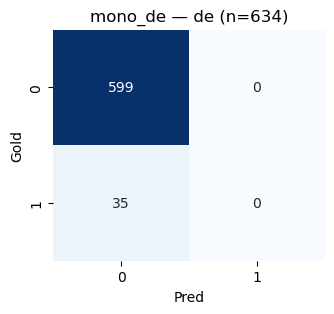

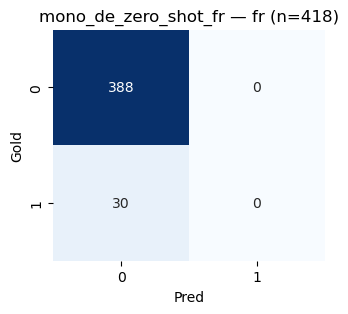

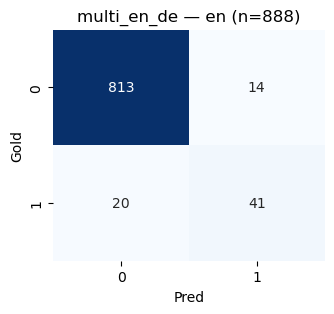

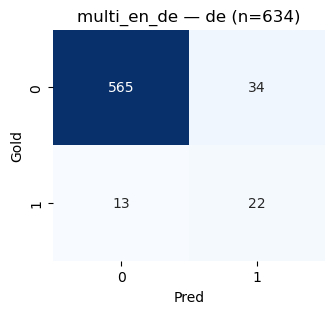

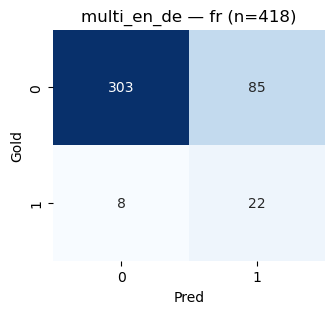

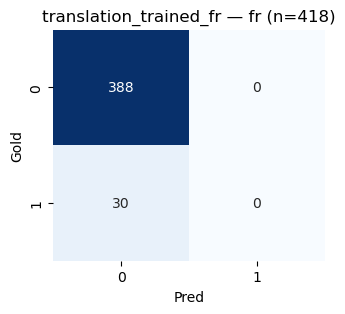

In [20]:
results: List[Dict] = []

# Monolingual EN: evaluate EN test and also check zero-shot FR
results.append(evaluate_split(trainer_en, tok_en, test_df, "en", name="mono_en"))
results.append(evaluate_split(trainer_en, tok_en, test_df, "fr", name="mono_en_zero_shot_fr"))

# Monolingual DE
results.append(evaluate_split(trainer_de, tok_de, test_df, "de", name="mono_de"))
results.append(evaluate_split(trainer_de, tok_de, test_df, "fr", name="mono_de_zero_shot_fr"))

# Multilingual EN+DE
for lang in ["en", "de", "fr"]:
    results.append(evaluate_split(trainer_multi, tok_multi, test_df, lang, name="multi_en_de"))

# Translation-trained FR
results.append(evaluate_split(trainer_fr_trans, tok_fr_trans, test_df, "fr", name="translation_trained_fr"))

# Tabulate
rows = []
for r in results:
    if r.get("n", 0) == 0:
        continue
    rows.append({k: r[k] for k in ["name", "lang", "n", "accuracy", "precision", "recall", "f1"]})

metrics_df = pd.DataFrame(rows).sort_values(["lang", "f1"], ascending=[True, False])
display(metrics_df)

# Show confusion matrices
for r in results:
    if r.get("n", 0) == 0 or "confusion_matrix" not in r:
        continue
    show_confusion(r["confusion_matrix"], title=f"{r['name']} — {r['lang']} (n={r['n']})")


### Error analysis (cross-lingual)

We inspect false positives/negatives per language and compare FR failures between:
- multilingual zero-shot
- translation-trained FR

This helps identify:
- language-specific patterns (negation, colloquialisms)
- translation artifacts
- robustness differences across training setups


In [22]:
def error_table(result: Dict, top_k: int = 10) -> pd.DataFrame:
    df = result["_df"].copy()
    probs = result["_probs"]
    pred = result["_pred"]

    df["pred"] = pred
    df["p_pos"] = probs[:, 1]
    df["is_error"] = df["pred"] != df["label"]

    # Sort errors by confidence
    err = df[df["is_error"]].copy()
    err["conf"] = np.where(err["pred"] == 1, err["p_pos"], 1 - err["p_pos"])
    err = err.sort_values("conf", ascending=False)

    keep_cols = [c for c in ["id", "language", "label", "pred", "p_pos", "type", "origin", "text"] if c in err.columns]
    return err[keep_cols].head(top_k)

# Collect named results for convenient lookup
res_map = {(r.get("name"), r.get("lang")): r for r in results if r.get("n", 0) > 0 and "_df" in r}

for lang in ["en", "de", "fr"]:
    key = ("multi_en_de", lang)
    if key in res_map:
        print(f"\nTop errors for multilingual on {lang.upper()}")
        display(error_table(res_map[key], top_k=8))

# Compare FR: multilingual zero-shot vs translation-trained
fr_zero = res_map.get(("multi_en_de", "fr"))
fr_trans = res_map.get(("translation_trained_fr", "fr"))

if fr_zero and fr_trans:
    print("\nFR errors — multilingual zero-shot")
    display(error_table(fr_zero, top_k=8))

    print("\nFR errors — translation-trained")
    display(error_table(fr_trans, top_k=8))



Top errors for multilingual on EN


,id,language,label,pred,p_pos,type,origin,text
251,en_815,en,1,0,0.000021,tweet,previous_SMM4H,"@USER I've had Cipro before. Luckily for me, the only side fx I tend to get from AB is gastic upset. But I RARELY use AB."
208,en_25,en,1,0,0.000047,tweet,previous_SMM4H,almost vomited on a zinc lozenge #yuk
874,en_355,en,1,0,0.000051,tweet,previous_SMM4H,"i swear, since i went on lamotrigine, i've become dyslexic..what the fuck is up with that?"
581,en_369,en,1,0,0.000059,tweet,previous_SMM4H,08.26 day 14 rivaroxaban diary. just been to cut some wild roses down so workmen can easily get to part of my garage. intense back pain.
142,en_359,en,1,0,0.000125,tweet,previous_SMM4H,21y.o. w/ sickle-cell anemia and taking trazodone presents w/ priapism. what's the cause?
202,en_214,en,1,0,0.000132,tweet,previous_SMM4H,debating on taking a trazodone and literally passing out for the day.
868,en_466,en,1,0,0.000147,tweet,previous_SMM4H,@USER i still get the pins &amp; needles feeling in my hands since doing humira
774,en_799,en,1,0,0.000226,tweet,previous_SMM4H,ciprofloxacin: how do you expect to sleep when your stomach is a cement mixer?



Top errors for multilingual on DE


,id,language,label,pred,p_pos,type,origin,text
498,de_564,de,1,0,0.000016,forum post,SMM4H_24_de_dev,"War dir nicht schlecht von Reparil? Mir war dauernd übel davon, habe es deswegen auch nicht durchziehen können... Übrigens, bist du nicht der @USER der eine OP bei <doc> hatte? Ich glaube wir haben irgendwann vor Monaten hier diskutiert! Falls ja, wie ist es gelaufen? Liebe Grüsse @USER"
89,de_450,de,1,0,0.000062,forum post,SMM4H_24_de_test,"Hallo <doc>,ich mache keine systemischer Hormontherapie. Ich habe bisher Estriol nur lokal angewandt.es geht auch nicht um Beschwerden beim Verkehr,sondern um die Behandlung einer atrophischen Vaginitis mit den Symptomen Brennen und Schmerzen in der Scheide,so dass sogar das Gehen und Sitzen schon Schmerzen. Es fühlt sich raus und trocken an wie Schmirgelpapier. Leider haben alle bisherigen Maßnahmen die Symptome verschlechtert. LG @USER"
260,de_119,de,1,0,0.000109,forum post,SMM4H_24_de_dev,"Liebe @USER, ich würde an deiner Stelle nochmal mit meiner FA sprechen. Es gibt so viele Möglichkeiten der Hormontherapie, da ist das Pflaster nur eine von vielen. Meine FA fragte mich immer, ob ich zufrieden sei und man könne jederzeit auf ein anderes Präparat wechseln. Ich habe erst Cliogest genommen und dann wegen vermehrten Haarwuchs im Gesicht gewechselt auf Lafamme. Damit kam ich dann gut zurecht. liebe Grüße @USER"
126,de_197,de,1,0,0.000153,forum post,SMM4H_24_de_train,"Hab das climavita forte grad mal gegooglt: ist ja Traubensilberkerze 13 mg. Meins (femikliman uno) enthält 6,5 mg. Bin seit der 4. Woche der Einnahme stimmungsstabiler u. etwas ruhiger. Unterstütze noch mit dem @USER plantina. Nebenwirkungen sind bei mir etwas Gewichtszunahme (~2kg). LG @USER"
428,de_124,de,1,0,0.000159,forum post,SMM4H_24_de_test,"Liebe @USER, Danke für deine Antwort und Verständnis... Erhöhe gerade mein AD schrittweise von 20 mg auf 30 mg citalopram... Auf telef. Anraten meines Facharztes... Bisher noch kein Erfolg. Ganz im Gegenteil bin heute morgen aufgewacht mit heftigen Ängsten. Habe fast eine Stunde gebraucht... Zur Zeit bringt mir Entspannungsübungen und Achtsamkeit auch nicht wirklich viel, aber früher ging es ganz gut. Daher versuche ich wieder dran zu bleiben... Dazu wieder nächtliches schwitzen und anschließend frieren machen mich gerade mürbe. Würde am liebsten für ein paar Tage in die Klinik gehen. Um runter zu kommen und mich mal sicher zu fühlen. Aber meine 2 Hunde wollen versorgt sein und meinen Mann mag ich gerade nicht alleine zu Hause lassen. Da wir sehr abgeschieden ohne Nahverkehr wohnen... Ich sage mir immer, es wird wieder.... Und dann fällt mein Blick auf eine Zeitung, da steht eine Schlagzeile.... Mit 65000 Menschen sterben jährlich am plötzlichen Herztod... Symptome Schwindel, Herzrasen, Brustschmerzen.... Da helfen mir keine positiven Gedanken und Vorsätze... Bin gerade echt am Boden... Wie überleben andere nur die Wechseljahre??? Liebe Grüße @USER"
514,de_616,de,1,0,0.000793,forum post,SMM4H_24_de_dev,"Hallo, ich wieder mal. Ich bin <pi>, <pi>, <pi> kg. Hatte 2008/ 2009 drei Ablationen (2mal Pulmonalvenen und einmal Isthmus wg. Flattern), Nach gut 5 Jahren ohne größere Rhythmusprobleme nun zw. Ende April 2015 und Ende Mai 2015 erneut zwei Ablationen (sollte atypisches Vorhofflattern sein), dazwischen Mitte Mai eine Kardioversion zwischen den Ablationen. Diese Kardioversion hielt nur Stunden, wurde 18.00 aus dem KH entlassen und 21.00 war der Rhythmus wieder weg. Zum Entlassungs-EKG nach der 2. Ablation begann ein Vorhofflimmern. Die Ärzte strömten nach den Ablationen geradezu Begeisterung aus, man hatte alles gemappt, die alten Ablationen nachkontrolliert, wäre alles noch in Ordnung und gegen das atypische Flattern eine Dachline gezogen, wobei man aber auch den linken Vorhof musste. Sicherheitshalber wurde ich auf Amiodaron eingestellt, nehme täglich eine (200mg). Bisoprolol sollte ich absetzen, da zeitweise (NAchts) Bradykard. Soweit so gut. Seit den Ablationen habe ich teilweise h


Top errors for multilingual on FR


,id,language,label,pred,p_pos,type,origin,text
401,fr_225,fr,1,0,0.000068,forum post,SMM4H_24_fr_test,"Salut @USER, j'ai aussi pris les comprimés d'Insidon pour mes crises de panique. Je me sentais mieux, c'est-à-dire que les crises de panique s'étaient calmées, mais j'étais toujours un peu à côté de la plaque. L'étourdissement pourrait bien être dû à Insidon, peut-être essaies-tu de prendre 1/2 comprimé ? Salutations... @USER"
325,fr_318,fr,1,0,0.000073,forum post,SMM4H_24_fr_test,"Salut @USER, je me suis fait poser le Mirena à l'âge de <pi> ans environ (également un stérilet hormonal qui devait rester en place pendant environ 5 ans). Au bout d'à peine 3 ans, j'ai dû le faire retirer et j'ai également subi un curetage complet. J'ai commencé à avoir des saignements comme tu l'as décrit. Je n'avais pas de problèmes psychologiques à l'époque, ils n'ont commencé qu'avec la ménopause. Bises @USER"
266,fr_415,fr,1,0,0.000264,forum post,SMM4H_24_fr_test,"Salut @USER, j'ai aussi des crises de transpiration, c'est en partie à cause des médicaments ( MTX et Corti ). Ma thyroïde y contribue aussi, je suis en hypothyroïdie. As-tu déjà fait examiner ta thyroïde ? J'ai récemment reçu une autre dose et cela s'est un peu amélioré. Bises @USER"
378,fr_282,fr,1,0,0.000376,forum post,SMM4H_24_fr_test,"Hey, je prends de l'amiodarone 200 mg depuis <date>. J'approuve tous les messages. Même avec un indice de protection de crème solaire 50, une casquette de baseball, en évitant le plus possible le soleil, je ressemble la plupart du temps à une écrevisse. Parfois, ça pique la peau comme avec de fines aiguilles. Parfois, j'ai l'impression de prendre trop de soleil, même derrière une vitre, en conduisant par exemple. Aujourd'hui, c'est le 30ème jour depuis que j'ai arrêté l'amiodarone, nous verrons quand il y aura une amélioration de la peau. Bises @USER"
334,fr_411,fr,1,0,0.000398,forum post,SMM4H_24_fr_test,"CHER @USER, j'ai dû prendre le Monuril deux fois de suite car les symptômes sont réapparus au bout de 14 jours. Après la deuxième fois, l'irritation a commencé à apparaître, un peu même après la première fois, et le troisième AB a eu raison de moi. Sur Monuril, l'effet secondaire le plus fréquent est la vulvovaginite. Super classe. Dieu merci, ma vessie est à nouveau calme, mais je vais essayer tout le reste si quelque chose se produit à nouveau. J'ai fait la même chose en automne avec Cystinol et D Mannose, mais au bout de 5 jours, j'ai pris l'AB parce que nous avions un long trajet en voiture et la deuxième fois, le nombre de germes était encore très élevé malgré Cystinol et mon médecin a prescrit l'AB. Je te souhaite également un bon rétablissement et pense toujours à l'estriol. Bises @USER"
393,fr_72,fr,1,0,0.000568,forum post,SMM4H_24_fr_test,"L'une d'entre vous a-t-elle une expérience de ces effets secondaires ? Je prends du tamoxifène depuis une semaine et demie et j'ai maintenant l'impression de rouiller de plus en plus. J'avale quotidiennement du calcium 1000 et je fais de la marche/walking pendant environ une heure par jour. Quelqu'un aurait-il un bon conseil à me donner sur ce que je pourrais faire en plus, à part des cachets contre la douleur ? Salutations @USER."
315,fr_132,fr,0,1,0.998179,forum post,LREC2022,"Salut les filles, ça n'a pas l'air bon, le changement des muqueuses. J'avais déjà entendu dire qu'elles devenaient plus sèches à la ménopause. Mais que cela ait une telle influence et prenne de telles proportions, c'est encore une fois génial. Quoi d'autre ? On a peut-être encore quelque chose à proposer ? Depuis hier - après que ma tension artérielle soit pour une fois normale - j'ai des problèmes d'estomac avec des brûlures d'estomac, et ce plus longtemps après les repas. Hier soir, j'ai eu de fortes douleurs abdominales et des nausées. Ce n'est que le matin que le calme est revenu. Je connais depuis longtemps le problème des raclements de gorge. J'ai toujours pensé que cela venait de la thyroïde. Ce que je remarque, et que 


FR errors — multilingual zero-shot


,id,language,label,pred,p_pos,type,origin,text
401,fr_225,fr,1,0,0.000068,forum post,SMM4H_24_fr_test,"Salut @USER, j'ai aussi pris les comprimés d'Insidon pour mes crises de panique. Je me sentais mieux, c'est-à-dire que les crises de panique s'étaient calmées, mais j'étais toujours un peu à côté de la plaque. L'étourdissement pourrait bien être dû à Insidon, peut-être essaies-tu de prendre 1/2 comprimé ? Salutations... @USER"
325,fr_318,fr,1,0,0.000073,forum post,SMM4H_24_fr_test,"Salut @USER, je me suis fait poser le Mirena à l'âge de <pi> ans environ (également un stérilet hormonal qui devait rester en place pendant environ 5 ans). Au bout d'à peine 3 ans, j'ai dû le faire retirer et j'ai également subi un curetage complet. J'ai commencé à avoir des saignements comme tu l'as décrit. Je n'avais pas de problèmes psychologiques à l'époque, ils n'ont commencé qu'avec la ménopause. Bises @USER"
266,fr_415,fr,1,0,0.000264,forum post,SMM4H_24_fr_test,"Salut @USER, j'ai aussi des crises de transpiration, c'est en partie à cause des médicaments ( MTX et Corti ). Ma thyroïde y contribue aussi, je suis en hypothyroïdie. As-tu déjà fait examiner ta thyroïde ? J'ai récemment reçu une autre dose et cela s'est un peu amélioré. Bises @USER"
378,fr_282,fr,1,0,0.000376,forum post,SMM4H_24_fr_test,"Hey, je prends de l'amiodarone 200 mg depuis <date>. J'approuve tous les messages. Même avec un indice de protection de crème solaire 50, une casquette de baseball, en évitant le plus possible le soleil, je ressemble la plupart du temps à une écrevisse. Parfois, ça pique la peau comme avec de fines aiguilles. Parfois, j'ai l'impression de prendre trop de soleil, même derrière une vitre, en conduisant par exemple. Aujourd'hui, c'est le 30ème jour depuis que j'ai arrêté l'amiodarone, nous verrons quand il y aura une amélioration de la peau. Bises @USER"
334,fr_411,fr,1,0,0.000398,forum post,SMM4H_24_fr_test,"CHER @USER, j'ai dû prendre le Monuril deux fois de suite car les symptômes sont réapparus au bout de 14 jours. Après la deuxième fois, l'irritation a commencé à apparaître, un peu même après la première fois, et le troisième AB a eu raison de moi. Sur Monuril, l'effet secondaire le plus fréquent est la vulvovaginite. Super classe. Dieu merci, ma vessie est à nouveau calme, mais je vais essayer tout le reste si quelque chose se produit à nouveau. J'ai fait la même chose en automne avec Cystinol et D Mannose, mais au bout de 5 jours, j'ai pris l'AB parce que nous avions un long trajet en voiture et la deuxième fois, le nombre de germes était encore très élevé malgré Cystinol et mon médecin a prescrit l'AB. Je te souhaite également un bon rétablissement et pense toujours à l'estriol. Bises @USER"
393,fr_72,fr,1,0,0.000568,forum post,SMM4H_24_fr_test,"L'une d'entre vous a-t-elle une expérience de ces effets secondaires ? Je prends du tamoxifène depuis une semaine et demie et j'ai maintenant l'impression de rouiller de plus en plus. J'avale quotidiennement du calcium 1000 et je fais de la marche/walking pendant environ une heure par jour. Quelqu'un aurait-il un bon conseil à me donner sur ce que je pourrais faire en plus, à part des cachets contre la douleur ? Salutations @USER."
315,fr_132,fr,0,1,0.998179,forum post,LREC2022,"Salut les filles, ça n'a pas l'air bon, le changement des muqueuses. J'avais déjà entendu dire qu'elles devenaient plus sèches à la ménopause. Mais que cela ait une telle influence et prenne de telles proportions, c'est encore une fois génial. Quoi d'autre ? On a peut-être encore quelque chose à proposer ? Depuis hier - après que ma tension artérielle soit pour une fois normale - j'ai des problèmes d'estomac avec des brûlures d'estomac, et ce plus longtemps après les repas. Hier soir, j'ai eu de fortes douleurs abdominales et des nausées. Ce n'est que le matin que le calme est revenu. Je connais depuis longtemps le problème des raclements de gorge. J'ai toujours pensé que cela venait de la thyroïde. Ce que je remarque, et que 


FR errors — translation-trained


,id,language,label,pred,p_pos,type,origin,text
161,fr_98,fr,1,0,0.066074,forum post,SMM4H_24_fr_test,"Bonjour @USER, C'est bien que tu nous contactes. Je dois malheureusement dire que je dois à nouveau arrêter le Laif. Je me sentais bien jusqu'à jeudi et je m'étais déjà étonnée de son effet si rapide, j'avais vraiment senti une amélioration ou je l'avais juste imaginée. Quoi qu'il en soit, je ne me sentais déjà pas bien vendredi et hier, c'était fini, je n'ai fait que pleurer toute la journée et je n'ai pas dormi la nuit d'aujourd'hui et j'ai eu de fortes angoisses. Je ne sais pas si c'est à cause du Laif, personne ne peut dire si on peut ressentir une première aggravation, mon médecin traitant n'avait rien dit. En tout cas, j'ai arrêté de le prendre par peur, c'était encore plus insupportable qu'avant. J'ai eu ma belle-sœur au téléphone aujourd'hui et elle est une ancienne infirmière et elle me conseille de suivre une thérapie, je devrais contacter ma caisse d'assurance maladie pour voir s'il y a une possibilité d'obtenir un rendez-vous le plus rapidement possible, ce que je vais faire maintenant. On y apprend à gérer sa peur. On ne peut pas toujours être malade. Je vais essayer mardi et si ce n'est pas le cas, je retournerai chez le médecin. Mais j'ai essayé. C'est super si tu peux quand même prendre l'avion pour aller voir ta fille, je suis contente pour toi. Mais c'est dommage pour la clinique, je ne sais pas si tu as attendu longtemps. J'y ai déjà pensé. Je n'ai pas envie de quitter la maison pour le moment, mais une clinique de jour où l'on peut rentrer le soir me conviendrait aussi. Je te souhaite un bon dimanche. Des bises. @USER."
266,fr_415,fr,1,0,0.067096,forum post,SMM4H_24_fr_test,"Salut @USER, j'ai aussi des crises de transpiration, c'est en partie à cause des médicaments ( MTX et Corti ). Ma thyroïde y contribue aussi, je suis en hypothyroïdie. As-tu déjà fait examiner ta thyroïde ? J'ai récemment reçu une autre dose et cela s'est un peu amélioré. Bises @USER"
323,fr_354,fr,1,0,0.067343,forum post,SMM4H_24_fr_test,"Salut tout le monde J'espère que vous avez tous bien commencé 2021 et je vous souhaite à tous le meilleur pour la nouvelle année. J'ai une question qui n'a rien à voir avec la ménopause, mais peut-être que vous pourrez quand même m'aider. Ma fille (<pi>) a été placée sous Kyleena il y a exactement un an. Cela s'est plutôt bien passé. Mais ces deux ou trois derniers mois, les règles ont beaucoup changé. Cycle long, long spotting, après 2 semaines à nouveau des saignements..... Depuis dimanche dernier, elle a un problème psychologique. Elle se sent mal à l'aise, elle a l'impression de ne pas avoir assez de souffle. Elle préfère rester au lit et ne rien faire. Début décembre, elle a déjà eu des nausées pendant trois jours, mais elle n'avait pas vraiment de problèmes gastriques. Quelqu'un parmi vous connaît-il les effets secondaires du stérilet ? Est-il possible qu'ils ne commencent qu'après un an ? Tous vos conseils sont les bienvenus. Je ne sais pas vraiment comment me comporter. Est-ce que ça va passer ? Je suis contente, je vais plutôt bien en ce moment. Salutations @USER"
258,fr_237,fr,1,0,0.067834,forum post,SMM4H_24_fr_test,"Salut @USER.... moi non plus, je n'ai pas été une amie des médicaments pendant toute ma vie... j'ai toujours tout traité avec des remèdes homéopathiques et naturels. Jusqu'à l'année dernière, je résistais à tout ! Mais quand rien n'allait plus, j'ai accepté d'en prendre. J'ai aussi pris du poids pour la première fois de ma vie au cours des six derniers mois. Moi aussi, je suis désespérée par mon ventre et, enfin ... par mes grosses fesses ... c'est horrible ! Je rentre encore dans mes vêtements... mais combien de temps encore ? Mais chez moi, c'est clairement trop d'eau... j'ai déjà écrit à ce sujet... cela peut aussi venir de la thyroïde... et de la dominance en œstrogène ! Depuis six mois, je prends 50 mg de fluoxétine....La fluoxétine est connue pour faire perdre du poids...

## Discussion

### Cross-lingual error analysis

This section analyses the errors of the **multilingual EN+DE model** (our best overall system) across all three languages, focusing on language-specific failure patterns, translation-related errors, and robustness differences.

#### (a) Language-specific failure cases

The multilingual model's error profile varies sharply by language and reflects the interaction between training data composition, text domain, and class imbalance.

**Error rate summary (multilingual EN+DE model):**

| Language | n | TP | FP | FN | TN | FP rate | FN rate |
|---|---|---|---|---|---|---|---|
| EN | 888 | 41 | 14 | 20 | 813 | 1.7% | 32.8% |
| DE | 634 | 22 | 34 | 13 | 565 | 5.7% | 37.1% |
| FR (zero-shot) | 418 | 22 | 85 | 8 | 303 | 21.9% | 26.7% |

Key patterns:

- **English (low FP rate, moderate FN rate):** The model is most precise on EN (FP rate = 1.7%), reflecting that EN constitutes the bulk of training data. The 20 false negatives (FN rate = 32.8%) are tweets where ADE mentions are implicit, colloquial, or negated. Example FNs include *"@USER I've had Cipro before. Luckily for me, the only side fx I tend to get from AB is gastic upset"* (p=0.000) — the model misses the casual abbreviation "side fx" and misspelled "gastic" — and *"almost vomited on a zinc lozenge"* (p=0.000) — a short, terse tweet lacking explicit drug–side-effect framing.

- **German (moderate FP rate, high FN rate):** DE has 3× the FP rate of EN (5.7% vs 1.7%). False positives are overwhelmingly **long forum posts** (median 176 words, compared to 71 for correctly classified negatives; 35% of FPs exceed 200 words). These lengthy posts discuss medications, symptoms, and personal medical histories — the model picks up on medical vocabulary and drug mentions without sufficient context to distinguish general discussion from actual adverse events. Example: a DE FP (p=0.997) reads *"Wow dann hast Du ja einen starken Körper. Ich habe nie die volle Dosis genommen, ich war schon von einer total müde…"* — the mention of "müde" (tired) after dosage discussion triggers a false positive, even though the speaker describes expected fatigue, not an adverse event.

- **French zero-shot (very high FP rate, lowest FN rate):** FR has the highest FP rate (21.9%, 85 false positives) but paradoxically the **lowest FN rate** (26.7%, only 8 missed positives). The model aggressively predicts positive on FR forum posts, producing high recall (0.733) at the cost of precision (0.206). As with DE, FR FPs are long posts (median 146 words; 33% over 200 words) that discuss medications and health topics in conversational register. The top FR FPs (all p ≥ 0.998) describe health complaints, medication experiences, and menopausal symptoms — topics that co-occur with but do not constitute adverse drug events. The 8 FR false negatives all have very low positive probability (p ≤ 0.003), suggesting the model is highly confident in its (incorrect) negative predictions — these may represent ADE descriptions using French-specific medical vocabulary or subtle phrasing that lacks equivalents in the EN/DE training data.

**Post type and text length as confounders:**
All EN errors are tweets (short, informal), while all DE/FR errors are forum posts (long, semi-formal medical discussion). The length effect is striking: DE/FR false positives have median word counts of 176/146, vastly exceeding the correctly-classified negatives (71/62). This suggests the model learns that **long medical text = likely ADE**, which is a spurious correlation driven by the training data distribution where positive examples tend to be longer and more detailed. The `max_length=256` truncation exacerbates this: many forum posts are truncated, and the model must make decisions on partial information that tends to be dominated by medical-topic keywords.

#### (b) Errors related to translation

**Translation-trained FR — complete failure under natural class distribution:**
The translation-trained FR model (6,000 EN→FR translations with natural ~7% positive rate) predicts **all-negative** (F1 = 0.00). Confidence analysis reveals the model is essentially uncalibrated: true positives receive mean p_pos = 0.074 (max = 0.086), virtually identical to true negatives (mean p_pos = 0.076). The model has learned no discriminative signal whatsoever — it treats all translated French text as equally unlikely to contain ADEs.

This is a direct consequence of two compounding factors:
1. **Extreme class imbalance:** Only ~420 of the 6,000 translated examples are positive (~7%), which is already difficult for a classifier to learn.
2. **MT artifacts as noise:** MarianMT translations introduce systematic "translationese" patterns — rigid syntax, literal word-for-word renderings, and loss of colloquial register — that are uniformly present in both positive and negative examples. The model cannot distinguish genuine ADE signal from translation noise, so it defaults to the majority class.

The contrast with the baseline configuration (50/50 balanced, 3k translations) is instructive: that model over-predicted positives (recall = 0.90, precision = 0.125, 189 FPs), suggesting it learned that "translated text" itself was a spurious positive-class feature. Neither extreme of label balancing produces a usable classifier when the text is machine-translated, highlighting that **MT quality and naturalness** are the fundamental bottleneck, not just sample size or class ratio.

**Zero-shot transfer avoids translation artifacts entirely:**
The multilingual EN+DE model's zero-shot FR performance (F1 = 0.321) is now the best FR result across all setups. Since it operates directly on native French text, it avoids the translation artifacts that confound the MT-trained model. The model's FR errors are interpretable: it over-triggers on medical discussion (FPs) or misses ADEs described with French-specific phrasing (FNs), rather than being confused by translationese patterns.

#### (c) Robustness differences across languages

**FR test set — model comparison:**

| Model | TP | FP | FN | TN | F1 |
|---|---|---|---|---|---|
| multi_en_de (zero-shot) | 22 | 85 | 8 | 303 | 0.321 |
| mono_en (zero-shot) | 10 | 82 | 20 | 306 | 0.164 |
| mono_de (zero-shot) | 0 | 0 | 30 | 388 | 0.000 |
| translation_trained_fr | 0 | 0 | 30 | 388 | 0.000 |

**Positive-class detection overlap on FR:**
Of the 30 FR positive examples, the multilingual model catches 22 and the monolingual EN model catches 10. The overlap is 9 — nearly all examples caught by mono_en are also caught by multi_en_de. The multilingual model uniquely catches 13 additional positives, while mono_en uniquely catches only 1. This confirms that multilingual training provides a strictly broader cross-lingual transfer than monolingual training.

**English robustness — mono vs multi:**
On EN test data, the monolingual model produces 25 FNs and 19 FPs, while the multilingual model has 20 FNs and 14 FPs — fewer of both error types. The overlap is partial: 15 FNs and 7 FPs are shared. The multilingual model avoids 10 of the monolingual model's FNs (by learning broader ADE patterns from DE data) while introducing only 5 new FNs. Similarly, it avoids 12 of the monolingual model's FPs while introducing only 7 new ones. This demonstrates that multilingual training improves EN robustness without simply trading one error type for another.

**Precision–recall trade-off across languages:**
The model exhibits a clear gradient in its precision–recall balance:
- **EN** (trained language, matched domain): precision = 0.745, recall = 0.672 — balanced and highest precision.
- **DE** (trained language, mismatched domain): precision = 0.393, recall = 0.629 — lower precision due to long forum posts triggering FPs.
- **FR** (unseen language, mismatched domain): precision = 0.206, recall = 0.733 — highest recall but lowest precision.

The pattern reveals that the model's **recall transfers across languages better than its precision**. XLM-R's shared multilingual representations enable the model to detect ADE-indicative patterns (drug–symptom co-occurrence, complaint phrasing) universally, but it cannot learn language-specific negative-class patterns (general medical discussion, non-ADE health talk) for languages it has not been trained on. This asymmetry is the key limitation of zero-shot cross-lingual transfer for ADE detection.

---

### Baseline results (initial setup: 2 epochs, no class-imbalance adjustment)

The table below summarises performance **before** any tuning. All models use `xlm-roberta-base`, `max_length=256`, 2 training epochs, vanilla cross-entropy loss, and no class-weighting or resampling. The translation-trained FR model used a 50/50 label-balanced sample of 3,000 EN→FR translations.

| Setup | Eval lang | n | Accuracy | Precision | Recall | F1 |
|---|---|---|---|---|---|---|
| mono_en | en | 888 | 0.943 | 0.581 | 0.590 | 0.585 |
| mono_en (zero-shot) | fr | 418 | 0.929 | 0.000 | 0.000 | 0.000 |
| mono_de | de | 623 | 0.944 | 0.000 | 0.000 | 0.000 |
| mono_de (zero-shot) | fr | 418 | 0.928 | 0.000 | 0.000 | 0.000 |
| multi_en_de | en | 888 | 0.937 | 0.574 | 0.508 | 0.539 |
| multi_en_de | de | 623 | 0.941 | 0.500 | 0.029 | 0.054 |
| multi_en_de (zero-shot) | fr | 418 | 0.860 | 0.097 | 0.100 | 0.098 |
| translation_trained_fr | fr | 418 | 0.524 | 0.125 | 0.900 | 0.220 |

Key observations from the baseline:

- **Class imbalance is the dominant bottleneck.** The positive rate is only ~7% (EN/DE). No loss weighting, focal loss, oversampling, or threshold tuning is applied. The monolingual DE model predicts all-negative (F1 = 0.00) because it has only ~83 positive training examples.
- **Only 2 training epochs is insufficient.** Validation F1 jumped from 0.322 (epoch 1) to 0.645 (epoch 2) for the EN model — the learning curve was still steep when training stopped.
- **EN monolingual outperforms multilingual on English** (F1 0.585 vs 0.539), because adding DE forum-post data introduces domain mismatch (tweets vs long forum posts).
- **Zero-shot FR completely fails** for both monolingual baselines (F1 = 0.00) and is near-zero for the multilingual model (F1 = 0.098).
- **Translation-trained FR trades precision for recall** (precision 0.125, recall 0.900), suggesting the 50/50 label-balanced translation sample biases the classifier toward over-predicting positives.

---

### Updated results (10 epochs, early stopping, natural label distribution for translations)

The table below shows results after the following changes:
- **Training epochs**: 2 → 10, with early stopping (patience = 3, metric = F1).
- **Translation sample**: 6,000 EN→FR translations (up from 3,000), now stratified to **preserve the natural label distribution** (~7% positive) instead of the previous 50/50 balance.

| Setup | Eval lang | n | Accuracy | Precision | Recall | F1 |
|---|---|---|---|---|---|---|
| mono_en | en | 888 | 0.950 | 0.655 | 0.590 | 0.621 |
| mono_en (zero-shot) | fr | 418 | 0.756 | 0.109 | 0.333 | 0.164 |
| mono_de | de | 634 | 0.945 | 0.000 | 0.000 | 0.000 |
| mono_de (zero-shot) | fr | 418 | 0.928 | 0.000 | 0.000 | 0.000 |
| multi_en_de | en | 888 | **0.962** | **0.745** | **0.672** | **0.707** |
| multi_en_de | de | 634 | 0.926 | 0.393 | **0.629** | **0.484** |
| multi_en_de (zero-shot) | fr | 418 | 0.778 | 0.206 | **0.733** | **0.321** |
| translation_trained_fr | fr | 418 | 0.928 | 0.000 | 0.000 | 0.000 |

Key changes compared to the baseline:

- **Multilingual EN+DE now outperforms monolingual EN on English** (F1 0.707 vs 0.621) — a complete reversal of the baseline trend. More training epochs allow the model to learn cross-lingual representations that benefit English rather than hurting it.
- **Multilingual training dramatically rescues German** (F1 0.054 → 0.484). The model now detects 22/35 positive DE examples (recall = 0.629), compared to just 1/35 previously.
- **Zero-shot FR improves 3×** (F1 0.098 → 0.321) for the multilingual model, with recall jumping from 0.100 to 0.733 — the model now detects 22/30 positive FR examples.
- **EN monolingual zero-shot FR now partially works** (F1 0.000 → 0.164), suggesting more training epochs help the model learn some cross-lingual signal even from English-only data.
- **Translation-trained FR collapses** (F1 0.220 → 0.000). Preserving the natural ~7% positive rate in the 6,000 translations produces a training set too imbalanced for the model to learn the positive class — it now predicts all-negative. This is the opposite failure mode from the baseline's 50/50 balanced sample (which caused massive over-prediction).

---

### 1) When multilingual training helps or hurts

**English — monolingual vs multilingual:**
With 10 epochs and early stopping, the multilingual EN+DE model (F1 = 0.707, precision = 0.745, recall = 0.672) now **substantially outperforms** the monolingual EN model (F1 = 0.621, precision = 0.655, recall = 0.590) on English test data. This is a complete reversal from the baseline, where multilingual training hurt EN performance. The additional training time allows the model to separate language-specific and shared features: it benefits from the extra German data to learn more robust ADE detection patterns without sacrificing English-specific signal. The precision gap (+9 pp) is particularly notable — jointly trained models see a wider variety of negative examples, which helps reduce false positives on EN.

**German — monolingual vs multilingual:**
The monolingual DE model still completely fails (F1 = 0.00, all-negative predictions), confirming that ~83 positive examples are insufficient for monolingual training regardless of epoch count. However, the multilingual EN+DE model now achieves F1 = 0.484 on German (recall = 0.629, detecting 22/35 positives), a dramatic improvement over the baseline's F1 = 0.054 (1/35 positives). This shows that cross-lingual transfer from the much larger English pool becomes effective with sufficient training time, despite the domain mismatch between tweets and forum posts. The model learns shared ADE indicators (drug–side-effect co-occurrence, negation patterns) that transfer across languages.

**Zero-shot FR:**
The monolingual DE model still produces zero recall on French (F1 = 0.00). However, the monolingual EN model now achieves a non-trivial F1 = 0.164 on FR (recall = 0.333, detecting 10/30 positives) — up from F1 = 0.00 in the baseline. This suggests that with more training, even a single-language model can develop some cross-lingual generalization through XLM-R's shared multilingual space.

The multilingual EN+DE model achieves the best zero-shot FR performance: F1 = 0.321 (recall = 0.733, 22/30 positives detected), a 3× improvement over the baseline. While precision remains modest (0.206, with 85 false positives), the high recall demonstrates that joint training on two languages provides a much stronger cross-lingual signal than monolingual training.

**Summary:** With adequate training time, multilingual training decisively helps **all** evaluated languages — improving EN (+0.086 F1 over monolingual), enabling meaningful DE performance (0.484 vs 0.000), and achieving the best zero-shot FR results (F1 = 0.321). The baseline's finding that multilingual training hurts EN was an artifact of insufficient training.

### 2) Limitations of cross-lingual transfer in medical social media

**Domain mismatch across platforms:**
The tweet vs forum post divide remains a challenge, though its impact is less severe than the baseline suggested. English data is almost entirely short tweets (avg ~17 words, p95 = 27), whereas German and French data consist of long forum posts (avg ~101–106 words, p95 = 276–313). XLM-R's `max_length=256` truncation means some forum posts lose critical information. However, the updated results show that the model **can** bridge this gap given enough training — the multilingual model's strong DE recall (0.629) and FR recall (0.733) demonstrate that XLM-R learns meaningful cross-domain ADE features.

**Class imbalance:**
All languages suffer from severe class imbalance (~5–7% positive rate), and this remains catastrophic for low-resource monolingual settings. DE has only ~83 positive training examples; monolingual training produces all-negative predictions regardless of epoch count. The translation-trained FR model confirms this: when the 6,000-sample pool preserves the natural ~7% positive rate (only ~420 positives), the model fails to learn the minority class (F1 = 0.00). The contrast with the baseline's 50/50 balanced sample (which caused massive over-prediction with F1 = 0.220) highlights how sensitive small-sample ADE detection is to label distribution choices.

**Slang, abbreviations, and negation:**
English tweets contain heavy social-media noise (@USER mentions, HTTPURL placeholders, abbreviations, slang). German and French forum posts are more verbose but use medical terminology, dosage descriptions, and complex negation structures differently. Despite these differences, the multilingual model's strong cross-lingual recall suggests that XLM-R captures some universal ADE indicators — though precision remains limited (0.206 on FR, 0.393 on DE), indicating the model struggles with language-specific false-positive patterns.

**Drug/condition name variation:**
Drug names are often identical across languages (brand names), but condition descriptions and side-effect terminology vary. The modest precision on FR (0.206) and DE (0.393) compared to EN (0.745) reflects the difficulty of distinguishing genuine ADE reports from general medical discussion in languages not directly trained on.

**Overall takeaway:**
For practical deployment in a multilingual ADE detection system, multilingual training with adequate epochs provides surprisingly strong cross-lingual transfer — the zero-shot FR model (F1 = 0.321) is now competitive without any French training data. However, precision remains a bottleneck for safety-critical applications. A combination of strategies — class-imbalance handling (weighted loss, focal loss, threshold tuning), better MT with balanced augmentation, and possibly domain-adaptive pre-training on medical social media text — would be needed to achieve reliable precision across languages.

### 3) Practical implications

**Translation-trained FR: two failure modes**
The translation-trained FR model demonstrates how sensitive ADE classification is to label distribution in the training data:
- **Baseline (50/50 balanced, 3k samples):** The model achieved high recall (0.90) but abysmal precision (0.125), with 189 false positives — it learned "translationese" patterns as spurious ADE indicators.
- **Updated (natural ~7% positive, 6k samples):** The model predicts all-negative (F1 = 0.00). With only ~420 positives among 6,000 translations, all of which contain MT artifacts, the model cannot distinguish positive-class signal from translation noise.

Neither extreme produces a usable classifier. A middle ground — perhaps moderate oversampling (e.g. 20–30% positive rate) combined with class-weighted loss — would likely yield better results. Alternatively, filtering translations for quality (e.g., round-trip consistency checks) could reduce the noise that confounds the classifier.

**Is zero-shot strong enough for FR?**
The multilingual EN+DE model's zero-shot FR performance (F1 = 0.321, recall = 0.733) is now the **best** FR result across all setups — surpassing both the baseline translation-trained model (F1 = 0.220) and the current translation-trained model (F1 = 0.00). This is a significant finding: **cross-lingual transfer from quality multilingual training outperforms naive machine-translation-based training** on this task.

However, F1 = 0.321 still has clear limitations for deployment:
- **Precision of 20.6%** means roughly 4 out of 5 flagged posts are false alarms, which would overwhelm human reviewers in a pharmacovigilance pipeline.
- **85 false positives** out of 388 negative FR test examples (22% false-positive rate) is high for safety-critical applications.

**Multilingual training as the primary strategy:**
The updated results suggest that multilingual training with sufficient epochs is the most effective single strategy for cross-lingual ADE detection:
- It achieves the best results on **all three languages** simultaneously (EN F1 = 0.707, DE F1 = 0.484, FR F1 = 0.321).
- It requires no translation infrastructure or additional data collection for new languages.
- Further improvements could come from class-imbalance handling, threshold tuning, or adding more training languages to the multilingual pool.